## Notebook for training GPR on DC dataset and generating set of suggestions

**Created on 10th August, 2023; modified on 18th February, 2024**

**Dataset: label_ecfp_pca_add_feat_082423.csv**

In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, PandasTools, Fragments, rdMolDescriptors, Descriptors, rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.PandasTools import ChangeMoleculeRendering
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser
# Silence non-critical RDKit warnings to minimize unnecessary outputs
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
## import train_test_split from sklearn
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel, Matern, ConstantKernel, DotProduct, PairwiseKernel 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.special import erf
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import SVG, display

import json
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.models import HoverTool, ColorBar, CategoricalColorMapper
from bokeh.transform import factor_cmap
from bokeh.plotting import figure, output_file, save
from bokeh.transform import linear_cmap
from bokeh.palettes import Turbo256, d3
import pdb
output_notebook()

Loading BokehJS ...

In [2]:
%%bash
pwd
ls -ltr

/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/AL-CE/08-22-23/campaign-4
total 4368
-rw-r--r--@ 1 riteshk  staff  2232610 Feb 18 14:46 sugg_gpr_bma_iter_4.ipynb


Finding smiles that have been labeled

In [6]:
df_unlabel = pd.read_csv('../campaign-3/unlabel_1mil_ecfp_pca_add_feat_iter_3.csv') ## unlabeled data created from iteration-3; initial unlabeled data (~1 mil)
df_unlabel.rename(columns={'Unnamed: 0':'index_1'}, inplace=True) ## change index accordingly, but original index is in index_0 column
df_unlabel

,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,...,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type
0,0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,...,0.258767,0.301779,-0.272648,73.052764,186.939685,1.0,0.0,150,50,2
1,1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,...,0.258767,0.301779,-0.272648,114.079313,186.939685,1.0,0.0,150,50,2
2,2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,...,0.258767,0.301779,-0.272648,116.094963,186.939685,1.0,0.0,150,50,2
3,3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,...,0.258767,0.301779,-0.272648,70.058995,186.939685,1.0,0.0,150,50,2
4,4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,...,0.258767,0.301779,-0.272648,72.044939,186.939685,1.0,0.0,150,50,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999925,999956,999994,CC1ON(C)C(C)C1S(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.771012,-1.078565,0.565077,0.216605,0.613562,-0.742397,...,0.008496,0.161338,0.109063,193.077264,144.001775,1.0,0.0,150,50,2
999926,999957,999995,COC(=O)C1(N2CCCN(C)C2=O)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.881747,0.625623,1.808971,0.306581,0.123581,-0.469934,...,0.008496,0.161338,0.109063,240.147392,144.001775,1.0,0.0,150,50,2
999927,999958,999996,COC(=O)N1CCC(OS(C)(=O)=O)CC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.700964,0.588889,1.459777,0.806459,-0.042994,-0.081386,...,0.008496,0.161338,0.109063,251.046358,144.001775,1.0,0.0,150,50,2
999928,999959,999997,CN(C)C(=O)CN(C)C(=O)C1CCCC1(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,0.558235,0.889818,-0.240008,-0.734436,0.749283,0.799906,...,0.008496,0.161338,0.109063,248.133634,144.001775,1.0,0.0,150,50,2


In [13]:
def get_row(ind):
    sm = df_unlabel.loc[df_unlabel['index_0'] == ind]['solv_comb_sm']
    return df_unlabel.loc[df_unlabel['solv_comb_sm'] == sm.values[0]]

In [28]:
row_1 = get_row(324225)
row_1

,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,...,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type
324200,324211,324225,COCCN(C)S(C)(=O)=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.997594,-0.587529,-0.084673,-0.766005,-0.003629,0.705357,...,0.258767,0.301779,-0.272648,167.061614,186.939685,1.0,0.0,150,50,2


In [26]:
# sm = Chem.MolFromSmiles('COCCOCCOCC(F)(F)C(F)F')
# sm = Chem.MolFromSmiles('CCCCOCCOCCOCCOC')
# sm = Chem.MolFromSmiles('CCCCCCOC')
# sm = Chem.MolFromSmiles('CCOC(=O)CN(C)CCOC')
# sm = Chem.MolFromSmiles('CN(C)CCOC')
sm = Chem.MolFromSmiles('CCOCCCl')
df_unlabel.loc[df_unlabel['solv_comb_sm'] == Chem.MolToSmiles(sm)]

,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,...,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type
7422,7423,7425,CCOCCCl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.76112,-1.609598,0.396423,0.137856,0.18154,0.205658,...,0.258767,0.301779,-0.272648,108.034193,186.939685,1.0,0.0,150,50,2
339307,339318,339333,CCOCCCl,[Li+].F[P-](F)(F)(F)(F)F,-0.76112,-1.609598,0.396423,0.137856,0.18154,0.205658,...,0.195230,0.319099,-0.209425,108.034193,151.980186,1.0,0.0,150,50,2
677832,677853,677880,CCOCCCl,[Li+].O=C1O[B-](F)(F)OC1=O,-0.76112,-1.609598,0.396423,0.137856,0.18154,0.205658,...,0.008496,0.161338,0.109063,108.034193,144.001775,1.0,0.0,150,50,2


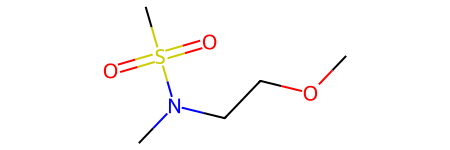

In [29]:
Chem.MolFromSmiles('COCCN(C)S(C)(=O)=O')

In [30]:
## Finding labaled data from 3rd campaign
label_iter_4 = pd.DataFrame(columns=df_unlabel.columns)
## the code below will only extract one solvent entry; but we want all three solvent entries
row_1 = get_row(266944) ## CAS: NA
row_2 = get_row(207608) ## CAS: 7382-30-1
row_3 = get_row(35574) ## CAS: 4747-07-3
row_4 = get_row(331858) ## CAS: 616882-60-1
row_5 = get_row(69602) ## CAS: 3030-44-2
row_6 = get_row(7425) ## CAS: 628-34-2
row_7 = get_row(324225) ## CAS: NA
label_iter_4 = pd.concat([label_iter_4, row_1, row_2, row_3, row_4, row_5, row_6, row_7], axis=0)
label_iter_4
# row_11

,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,...,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type
266920,266930,266944,COCCOCCOCC(F)(F)C(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.190545,-1.129056,1.030187,-0.668465,-0.151808,-0.097468,...,0.258767,0.301779,-0.272648,234.087907,186.939685,1.0,0.0,150,50,2
623743,623764,623790,COCCOCCOCC(F)(F)C(F)F,[Li+].F[P-](F)(F)(F)(F)F,-1.190545,-1.129056,1.030187,-0.668465,-0.151808,-0.097468,...,0.195230,0.319099,-0.209425,234.087907,151.980186,1.0,0.0,150,50,2
897006,897035,897073,COCCOCCOCC(F)(F)C(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,-1.190545,-1.129056,1.030187,-0.668465,-0.151808,-0.097468,...,0.008496,0.161338,0.109063,234.087907,144.001775,1.0,0.0,150,50,2
207587,207596,207608,CCCCOCCOCCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.067892,-1.253529,0.602357,0.775134,-0.714364,1.295648,...,0.258767,0.301779,-0.272648,220.167459,186.939685,1.0,0.0,150,50,2
466040,466059,466083,CCCCOCCOCCOCCOC,[Li+].F[P-](F)(F)(F)(F)F,-1.067892,-1.253529,0.602357,0.775134,-0.714364,1.295648,...,0.195230,0.319099,-0.209425,220.167459,151.980186,1.0,0.0,150,50,2
790022,790050,790085,CCCCOCCOCCOCCOC,[Li+].O=C1O[B-](F)(F)OC1=O,-1.067892,-1.253529,0.602357,0.775134,-0.714364,1.295648,...,0.008496,0.161338,0.109063,220.167459,144.001775,1.0,0.0,150,50,2
35569,35571,35574,CCCCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.308256,-1.863069,0.558941,1.032228,-0.733941,1.279644,...,0.258767,0.301779,-0.272648,116.120115,186.939685,1.0,0.0,150,50,2
386668,386684,386703,CCCCCCOC,[Li+].F[P-](F)(F)(F)(F)F,-1.308256,-1.863069,0.558941,1.032228,-0.733941,1.279644,...,0.195230,0.319099,-0.209425,116.120115,151.980186,1.0,0.0,150,50,2
733560,733586,733618,CCCCCCOC,[Li+].O=C1O[B-](F)(F)OC1=O,-1.308256,-1.863069,0.558941,1.032228,-0.733941,1.279644,...,0.008496,0.161338,0.109063,116.120115,144.001775,1.0,0.0,150,50,2
331833,331844,331858,CCOC(=O)CN(C)CCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.618370,0.619338,0.080507,0.000244,0.093421,0.996731,...,0.258767,0.301779,-0.272648,175.120843,186.939685,1.0,0.0,150,50,2


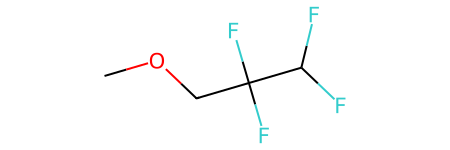

In [137]:
Chem.MolFromSmiles('COC(CC(F)(F)F)OC')
# Chem.MolFromSmiles('COCCC(C)(OC)OC')
# Chem.MolFromSmiles('COCC(C)OC')
# Chem.MolFromSmiles('CO[Si](CCC(F)(F)C(F)(F)C(F)(F)F)(OC)OC')
Chem.MolFromSmiles('COCCOCOCC(F)(F)F')
# Chem.MolFromSmiles('COC(CCl)OC')
# Chem.MolFromSmiles('COC(F)(F)C(F)Cl')
# Chem.MolFromSmiles('COC(C)CC(OC)OC')
# Chem.MolFromSmiles('CCCOC')
Chem.MolFromSmiles('COC(OC)C(F)(F)F')
Chem.MolFromSmiles('COCC(F)(F)C(F)F')

In [31]:
label_iter_4['solv_comb_sm'].unique()

array(['COCCOCCOCC(F)(F)C(F)F', 'CCCCOCCOCCOCCOC', 'CCCCCCOC',
       'CCOC(=O)CN(C)CCOC', 'COCCN(C)C', 'CCOCCCl', 'COCCN(C)S(C)(=O)=O'],
      dtype=object)

In [32]:
df_unlabel_ = df_unlabel.drop(label_iter_4.index) ## drop the labeled molecules from the unlabeled data
df_unlabel_

,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,...,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type
0,0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,...,0.258767,0.301779,-0.272648,73.052764,186.939685,1.0,0.0,150,50,2
1,1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,...,0.258767,0.301779,-0.272648,114.079313,186.939685,1.0,0.0,150,50,2
2,2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,...,0.258767,0.301779,-0.272648,116.094963,186.939685,1.0,0.0,150,50,2
3,3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,...,0.258767,0.301779,-0.272648,70.058995,186.939685,1.0,0.0,150,50,2
4,4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,...,0.258767,0.301779,-0.272648,72.044939,186.939685,1.0,0.0,150,50,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999925,999956,999994,CC1ON(C)C(C)C1S(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.771012,-1.078565,0.565077,0.216605,0.613562,-0.742397,...,0.008496,0.161338,0.109063,193.077264,144.001775,1.0,0.0,150,50,2
999926,999957,999995,COC(=O)C1(N2CCCN(C)C2=O)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.881747,0.625623,1.808971,0.306581,0.123581,-0.469934,...,0.008496,0.161338,0.109063,240.147392,144.001775,1.0,0.0,150,50,2
999927,999958,999996,COC(=O)N1CCC(OS(C)(=O)=O)CC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.700964,0.588889,1.459777,0.806459,-0.042994,-0.081386,...,0.008496,0.161338,0.109063,251.046358,144.001775,1.0,0.0,150,50,2
999928,999959,999997,CN(C)C(=O)CN(C)C(=O)C1CCCC1(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,0.558235,0.889818,-0.240008,-0.734436,0.749283,0.799906,...,0.008496,0.161338,0.109063,248.133634,144.001775,1.0,0.0,150,50,2


In [33]:
df_unlabel_.to_csv('unlabel_1mil_ecfp_pca_add_feat_iter_4.csv') ## save the unlabeled data for the next iteration
# df_unlabel_ = pd.read_csv('unlabel_1mil_ecfp_pca_add_feat_iter_3.csv') ## read the unlabeled data for the next iteration
# df_unlabel_

In [34]:
label_iter_4.to_csv('just_label_iter_4.csv', index=False) ## also save the labeled data from the 1st iteration of suggestions
# label_iter_3 = pd.read_csv('just_label_iter_4.csv') ## read the labeled data labeled data from the 1st iteration of suggestions
# label_iter_3

In [35]:
df = pd.read_csv('label_ecfp_pca_add_feat_iter_4_021824.csv') ## added the labeled data from the 3rd iteration of suggestions to the labeled data from 2nd iteration manually
df

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,norm_capacity_14,norm_capacity_15,norm_capacity_16,norm_capacity_17,norm_capacity_18,norm_capacity_19,norm_capacity_20,norm_capacity_21,norm_capacity_22,norm_capacity_23
0,COCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.845301,-0.995151,1.062720,-0.357552,-0.308720,0.309456,0.693325,0.613072,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
1,COCCOC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.183255,-0.948338,0.615257,-0.582269,-1.010187,-0.522075,0.496896,0.301582,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
2,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,...,0.022233,0.02168,0.022967,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
3,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,...,0.000573,0.00046,0.000360,0.000407,0.0006,0.000593,0.000447,0.000333,0.0,0.0
4,CCOCCOC(C)(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.879184,-1.539457,0.507075,-0.111830,0.800175,0.133053,0.926130,-0.208395,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,COCCN(C)C,[Li+].O=C1O[B-](F)(F)OC1=O,-0.910508,-0.897028,-0.304000,-0.934742,-0.208599,0.859589,0.955882,1.288009,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
127,CCOCCCl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.761120,-1.609598,0.396423,0.137856,0.181540,0.205658,0.102161,0.166661,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
128,CCOCCCl,[Li+].F[P-](F)(F)(F)(F)F,-0.761120,-1.609598,0.396423,0.137856,0.181540,0.205658,0.102161,0.166661,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
129,CCOCCCl,[Li+].O=C1O[B-](F)(F)OC1=O,-0.761120,-1.609598,0.396423,0.137856,0.181540,0.205658,0.102161,0.166661,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0


In [36]:
df['theor_capacity'].unique()

array([150, 203, 161])

In [37]:
## Important change: on 24th August, 2023
df_ = df.copy()
df_.drop(['conc_salt_2', 'pressure_type'], axis=1, inplace=True) ## dropping 'conc_salt_2' and 'pressure_type' columns as I think may not be that important
df_

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,norm_capacity_14,norm_capacity_15,norm_capacity_16,norm_capacity_17,norm_capacity_18,norm_capacity_19,norm_capacity_20,norm_capacity_21,norm_capacity_22,norm_capacity_23
0,COCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.845301,-0.995151,1.062720,-0.357552,-0.308720,0.309456,0.693325,0.613072,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
1,COCCOC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.183255,-0.948338,0.615257,-0.582269,-1.010187,-0.522075,0.496896,0.301582,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
2,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,...,0.022233,0.02168,0.022967,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
3,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,...,0.000573,0.00046,0.000360,0.000407,0.0006,0.000593,0.000447,0.000333,0.0,0.0
4,CCOCCOC(C)(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.879184,-1.539457,0.507075,-0.111830,0.800175,0.133053,0.926130,-0.208395,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,COCCN(C)C,[Li+].O=C1O[B-](F)(F)OC1=O,-0.910508,-0.897028,-0.304000,-0.934742,-0.208599,0.859589,0.955882,1.288009,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
127,CCOCCCl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.761120,-1.609598,0.396423,0.137856,0.181540,0.205658,0.102161,0.166661,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
128,CCOCCCl,[Li+].F[P-](F)(F)(F)(F)F,-0.761120,-1.609598,0.396423,0.137856,0.181540,0.205658,0.102161,0.166661,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
129,CCOCCCl,[Li+].O=C1O[B-](F)(F)OC1=O,-0.761120,-1.609598,0.396423,0.137856,0.181540,0.205658,0.102161,0.166661,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0


In [38]:
X = df_.iloc[:,2:27]
y = df_['norm_capacity_3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) ## will be using complete dataset for training
X_test

,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,solv_ecfp_pca_8,solv_ecfp_pca_9,...,salt_ecfp_pca_5,salt_ecfp_pca_6,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,theor_capacity,amt_electrolyte
55,-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,-0.615222,-0.539429,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,111.999429,186.939685,2.0,150,50
40,-1.190545,-1.129056,1.030187,-0.668465,-0.151808,-0.097468,1.281233,0.277076,-0.442167,-0.403692,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,190.061692,186.939685,1.0,203,50
19,-0.577399,-1.639612,0.670798,-0.294002,0.253209,-0.028375,0.349185,0.283212,-0.829724,-0.518639,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,154.080536,186.939685,1.0,150,50
31,-0.687319,-1.062975,1.246791,-0.438504,-0.324318,0.383256,0.514114,0.764953,-1.026413,0.076663,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,156.078644,186.939685,1.0,150,50
115,-0.743406,-1.487900,0.912048,-0.821155,0.293529,-0.651772,0.598413,-0.220786,-0.090747,-0.328343,...,0.203690,-0.160053,0.195230,0.319099,-0.209425,147.990277,151.980186,1.0,150,50
56,-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,-0.615222,-0.539429,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,111.999429,186.939685,4.0,203,50
69,0.544321,-0.787394,0.681496,-0.289700,0.458624,0.255901,-0.920301,0.736245,0.100207,-1.007396,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,126.104465,186.939685,1.0,150,50
105,-0.898381,-1.467829,1.086570,-0.709556,0.226229,0.227359,1.573875,0.327258,-0.089751,-0.204551,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,148.109944,186.939685,1.0,150,50
81,1.447440,-1.230973,0.492616,-0.724459,0.302936,0.289000,-0.715427,-0.300911,0.172511,-1.202537,...,0.203690,-0.160053,0.195230,0.319099,-0.209425,154.036084,151.980186,1.0,150,50
26,-0.843804,-0.934786,1.100089,-0.357726,-0.344566,0.308553,0.688237,0.572082,-0.786094,-0.396651,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,236.143119,186.939685,1.0,150,50


In [39]:
std_scale_ = StandardScaler().fit(X)
X_std = std_scale_.transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)

In [40]:
kernel_1 = PairwiseKernel(metric='polynomial') + WhiteKernel(noise_level=0.1)
kernel_3 = RBF(length_scale=0.01) + WhiteKernel(noise_level=0.1)
kernel_2 = Matern(length_scale=0.01, nu=2.5) + WhiteKernel(noise_level=0.1)
kernel_4 = Matern(length_scale=0.01, nu=1.5) + WhiteKernel(noise_level=0.1)
kernel_5 = ExpSineSquared(length_scale=0.01, periodicity=1.0) + WhiteKernel(noise_level=0.1)
kernel_6 = RationalQuadratic(length_scale=0.01, alpha=1.0) + WhiteKernel(noise_level=0.1)
kernel_7 = DotProduct(sigma_0=0.1) + WhiteKernel(noise_level=0.1)
kernel_8 = RBF(length_scale=0.01) + ExpSineSquared(length_scale=0.01, periodicity=1.0) + WhiteKernel(noise_level=0.1)
kernels = [kernel_1, kernel_2, kernel_3, kernel_4, kernel_5, kernel_6, kernel_7, kernel_8]
kernel_name = ['PairwiseKernel', 'Matern 5/2', 'RBF', 'Matern 3/2', 'ExpSineSquared', 'RationalQuadratic', 'DotProduct', 'RBF+ExpSineSquared']
cv_dict = {'kernel': list(), 'score': list()}

In [41]:
# def negative_log_likelihood(noise_level, length_scale, alpha, kernel_name):
# def negative_log_likelihood(params, kernel_name):
def negative_log_likelihood_rbf(params):
    noise_level, length_scale, alpha = params ## for adding regularization parameter
    # noise_level, length_scale = params ## in case of not adding regularization parameter
    # if kernel_name == 'RBF':
    kernel = RBF(length_scale=length_scale)
    # elif kernel_name == 'Matern-5/2':
        # kernel = Matern(length_scale=length_scale, nu=2.5)
    # elif kernel_name == 'Pairwise':
        # kernel = PairwiseKernel(metric='polynomial')
    white_kernel = WhiteKernel(noise_level=noise_level)
    composite_kernel = kernel + white_kernel
    gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42) ## for adding regularization parameter
    # gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=0.0, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=0) ## in case of not adding regularization parameter
    gpr.fit(X_std, y)
    pred_mean, pred_std = gpr.predict(X_std, return_std=True)
    log_likelihood = np.sum(norm.logpdf(y, loc=pred_mean, scale=pred_std))
    return -log_likelihood

def negative_log_likelihood_rq(params):
    noise_level, length_scale, alpha_k, alpha = params ## for adding regularization parameter
    kernel = RationalQuadratic(length_scale=length_scale, alpha=alpha_k)
    white_kernel = WhiteKernel(noise_level=noise_level)
    composite_kernel = kernel + white_kernel
    gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42) ## for adding regularization parameter
    gpr.fit(X_std, y)
    pred_mean, pred_std = gpr.predict(X_std, return_std=True)
    log_likelihood = np.sum(norm.logpdf(y, loc=pred_mean, scale=pred_std))
    return -log_likelihood

def negative_log_likelihood_rbf_expsin(params):
    noise_level, length_scale, periodicity, alpha = params ## for adding regularization parameter
    kernel = RBF(length_scale=length_scale) + ExpSineSquared(length_scale=length_scale, periodicity=periodicity)
    white_kernel = WhiteKernel(noise_level=noise_level)
    composite_kernel = kernel + white_kernel
    gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42) ## for adding regularization parameter
    gpr.fit(X_std, y)
    pred_mean, pred_std = gpr.predict(X_std, return_std=True)
    log_likelihood = np.sum(norm.logpdf(y, loc=pred_mean, scale=pred_std))
    return -log_likelihood

def negative_log_likelihood_matern(params):
    noise_level, length_scale, alpha = params
    kernel = Matern(length_scale=length_scale, nu=1.5)
    white_kernel = WhiteKernel(noise_level=noise_level)
    composite_kernel = kernel + white_kernel
    gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
    gpr.fit(X_std, y)
    pred_mean, pred_std = gpr.predict(X_std, return_std=True)
    log_likelihood = np.sum(norm.logpdf(y, loc=pred_mean, scale=pred_std))
    return -log_likelihood

def negative_log_likelihood_pairwise(params):
    noise_level, length_scale, alpha = params
    kernel = PairwiseKernel(metric="polynomial")
    white_kernel = WhiteKernel(noise_level=noise_level)
    composite_kernel = kernel + white_kernel
    gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
    gpr.fit(X_std, y)
    pred_mean, pred_std = gpr.predict(X_std, return_std=True)
    log_likelihood = np.sum(norm.logpdf(y, loc=pred_mean, scale=pred_std))
    return -log_likelihood

**Optimize Pairwise kernel**

In [42]:
initial_guess = [0.15, 0.01, 0.02] # initial guess for noise_level, length_scale, alpha
param_bounds = [(1e-4, 1.0), (1e-5, 50.0), (1e-4, 0.1)] # bounds for noise_level, length_scale, alpha
result = minimize(negative_log_likelihood_pairwise, initial_guess, bounds=param_bounds)
optimized_hyperparameters = result.x
optimized_noise_level, optimized_length_scale, optimized_alpha = optimized_hyperparameters
print("Optimized noise_level:", optimized_noise_level)
print("Optimized length_scale:", optimized_length_scale)
print("Optimized alpha:", optimized_alpha)

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of i

Optimized noise_level: 0.1500092841314448
Optimized length_scale: 0.01
Optimized alpha: 0.0001


In [43]:
optimized_kernel = PairwiseKernel(metric="polynomial") + WhiteKernel(noise_level=optimized_noise_level)
gpr_optimized = GaussianProcessRegressor(kernel=optimized_kernel, alpha=optimized_alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
gpr_optimized.fit(X_std, y)
y_pred, y_uncer = gpr_optimized.predict(X_std, return_std=True)
print("R2 score:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


R2 score: 0.5645356612889088
MAE: 0.15374589784788117
RMSE: 0.1952331642144144


/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [44]:
gpr_optimized.get_params()
gpr_optimized.log_marginal_likelihood(gpr_optimized.kernel_.theta)
gpr_optimized.kernel_

PairwiseKernel(gamma=0.0007246685548301167, metric=polynomial) + WhiteKernel(noise_level=0.0432)

In [45]:
pred_df = pd.DataFrame({'y': y, 'y_pred': y_pred, 'y_uncer': y_uncer})
pred_df

,y,y_pred,y_uncer
0,0.276580,0.324106,0.214283
1,0.661460,0.272855,0.214641
2,0.178387,0.311660,0.215325
3,0.216953,0.311660,0.215325
4,0.026187,0.475053,0.222160
...,...,...,...
126,0.000007,-0.015150,0.238985
127,0.000000,0.247771,0.213846
128,0.000000,0.101135,0.219633
129,0.000000,0.080511,0.220722


**Optimize RationalQuadratic kernel**

In [46]:
initial_guess = [0.15, 0.01, 0.01, 0.02] # initial guess for noise_level, length_scale, alpha_k, alpha
param_bounds = [(1e-4, 1.0), (1e-5, 50.0), (1e-5, 50.0), (1e-4, 0.1)] # bounds for noise_level, length_scale, alpha_k, alpha
result = minimize(negative_log_likelihood_rq, initial_guess, bounds=param_bounds)
optimized_hyperparameters = result.x
optimized_noise_level, optimized_length_scale, optimized_alpha_k, optimized_alpha = optimized_hyperparameters
print("Optimized noise_level:", optimized_noise_level)
print("Optimized length_scale:", optimized_length_scale)
print("Optimized alpha_k:", optimized_alpha_k)
print("Optimized alpha:", optimized_alpha)

Optimized noise_level: 0.1499829023821723
Optimized length_scale: 0.0100577156322445
Optimized alpha_k: 0.011221296456641765
Optimized alpha: 0.017084109897403145


In [47]:
optimized_kernel = RationalQuadratic(length_scale=optimized_length_scale, alpha=optimized_alpha_k) + WhiteKernel(noise_level=optimized_noise_level)
gpr_optimized = GaussianProcessRegressor(kernel=optimized_kernel, alpha=optimized_alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
gpr_optimized.fit(X_std, y)
y_pred, y_uncer = gpr_optimized.predict(X_std, return_std=True)
print("R2 score:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

R2 score: 0.8332151624271456
MAE: 0.08068003985339686
RMSE: 0.12082465913967017


In [48]:
gpr_optimized.get_params()
gpr_optimized.log_marginal_likelihood(gpr_optimized.kernel_.theta)
gpr_optimized.kernel_

RationalQuadratic(alpha=0.0111, length_scale=6.76) + WhiteKernel(noise_level=0.00815)

In [49]:
pred_df = pd.DataFrame({'y': y, 'y_pred': y_pred, 'y_uncer': y_uncer})
pred_df

,y,y_pred,y_uncer
0,0.276580,0.294079,0.124729
1,0.661460,0.342094,0.126554
2,0.178387,0.294130,0.122908
3,0.216953,0.294130,0.122908
4,0.026187,0.209319,0.148670
...,...,...,...
126,0.000007,0.020270,0.156535
127,0.000000,0.311743,0.127980
128,0.000000,0.042053,0.149198
129,0.000000,0.021397,0.149682


**Optimize Matern-3/2 kernel**

In [50]:
initial_guess = [0.15, 0.01, 0.02] # initial guess for noise_level, length_scale, alpha
param_bounds = [(1e-4, 1.0), (1e-5, 50.0), (1e-4, 0.1)] # bounds for noise_level, length_scale, alpha
result = minimize(negative_log_likelihood_matern, initial_guess, bounds=param_bounds)
optimized_hyperparameters = result.x
optimized_noise_level, optimized_length_scale, optimized_alpha = optimized_hyperparameters
print("Optimized noise_level:", optimized_noise_level)
print("Optimized length_scale:", optimized_length_scale)
print("Optimized alpha:", optimized_alpha)

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warning

Optimized noise_level: 0.15
Optimized length_scale: 0.01
Optimized alpha: 0.009608076929572357


In [51]:
optimized_kernel = Matern(length_scale=optimized_length_scale, nu=1.5) + WhiteKernel(noise_level=optimized_noise_level)
gpr_optimized = GaussianProcessRegressor(kernel=optimized_kernel, alpha=optimized_alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
gpr_optimized.fit(X_std, y)
y_pred, y_uncer = gpr_optimized.predict(X_std, return_std=True)
print("R2 score:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

R2 score: 0.635337621171539
MAE: 0.1294893114435534
RMSE: 0.17865812664760325


In [52]:
gpr_optimized.get_params()
gpr_optimized.log_marginal_likelihood(gpr_optimized.kernel_.theta)
gpr_optimized.kernel_

Matern(length_scale=31, nu=1.5) + WhiteKernel(noise_level=0.0291)

In [53]:
pred_df = pd.DataFrame({'y': y, 'y_pred': y_pred, 'y_uncer': y_uncer})
pred_df

,y,y_pred,y_uncer
0,0.276580,0.325654,0.180618
1,0.661460,0.288034,0.181055
2,0.178387,0.320694,0.182054
3,0.216953,0.320694,0.182054
4,0.026187,0.454246,0.193620
...,...,...,...
126,0.000007,-0.024703,0.218607
127,0.000000,0.260606,0.180562
128,0.000000,0.079437,0.192709
129,0.000000,0.053258,0.195572


**Optimize RBF-ExpineSquared kernel**

In [54]:
initial_guess = [0.15, 0.01, 1.0, 0.02] # initial guess for noise_level, length_scale, periodicity, alpha
param_bounds = [(1e-4, 1.0), (1e-5, 50.0), (1e-2, 10.0), (1e-4, 0.1)] # bounds for noise_level, length_scale, periodicity, alpha
result = minimize(negative_log_likelihood_rbf_expsin, initial_guess, bounds=param_bounds)
optimized_hyperparameters = result.x
optimized_noise_level, optimized_length_scale, optimized_periodicity, optimized_alpha = optimized_hyperparameters
print("Optimized noise_level:", optimized_noise_level)
print("Optimized length_scale:", optimized_length_scale)
print("Optimized periodicity:", optimized_periodicity)
print("Optimized alpha:", optimized_alpha)

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warning

Optimized noise_level: 0.15
Optimized length_scale: 0.01
Optimized periodicity: 1.0
Optimized alpha: 0.020000844738704397


In [55]:
optimized_kernel = RBF(length_scale=optimized_length_scale) + ExpSineSquared(length_scale=optimized_length_scale, periodicity=optimized_periodicity) + WhiteKernel(noise_level=optimized_noise_level)
gpr_optimized = GaussianProcessRegressor(kernel=optimized_kernel, alpha=optimized_alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
gpr_optimized.fit(X_std, y)
y_pred, y_uncer = gpr_optimized.predict(X_std, return_std=True)
print("R2 score:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

R2 score: 0.6081878295227978
MAE: 0.13877789736512633
RMSE: 0.18518945620443739


In [56]:
gpr_optimized.get_params()
gpr_optimized.log_marginal_likelihood(gpr_optimized.kernel_.theta)
gpr_optimized.kernel_

RBF(length_scale=16.7) + ExpSineSquared(length_scale=80.7, periodicity=0.00101) + WhiteKernel(noise_level=0.0216)

In [57]:
pred_df = pd.DataFrame({'y': y, 'y_pred': y_pred, 'y_uncer': y_uncer})
pred_df

,y,y_pred,y_uncer
0,0.276580,0.338202,0.157003
1,0.661460,0.295164,0.157681
2,0.178387,0.325906,0.158626
3,0.216953,0.325906,0.158626
4,0.026187,0.478979,0.170889
...,...,...,...
126,0.000007,-0.041758,0.199733
127,0.000000,0.248941,0.156625
128,0.000000,0.080943,0.167555
129,0.000000,0.065020,0.170907


**Production runs**

In [58]:
# df_unlabel = pd.read_csv('unlabel_1mil_ecfp_pca_add_feat.csv')
# df_unlabel_ = df_unlabel.copy()
df_unlabel_.drop(['conc_salt_2', 'pressure_type'], axis=1, inplace=True) ## dropping 'conc_salt_2' and 'pressure_type' columns as I think may not be that important
df_unlabel_

,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,...,salt_ecfp_pca_5,salt_ecfp_pca_6,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,theor_capacity,amt_electrolyte
0,0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,73.052764,186.939685,1.0,150,50
1,1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,114.079313,186.939685,1.0,150,50
2,2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,116.094963,186.939685,1.0,150,50
3,3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,70.058995,186.939685,1.0,150,50
4,4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,72.044939,186.939685,1.0,150,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999925,999956,999994,CC1ON(C)C(C)C1S(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.771012,-1.078565,0.565077,0.216605,0.613562,-0.742397,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,193.077264,144.001775,1.0,150,50
999926,999957,999995,COC(=O)C1(N2CCCN(C)C2=O)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.881747,0.625623,1.808971,0.306581,0.123581,-0.469934,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,240.147392,144.001775,1.0,150,50
999927,999958,999996,COC(=O)N1CCC(OS(C)(=O)=O)CC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.700964,0.588889,1.459777,0.806459,-0.042994,-0.081386,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,251.046358,144.001775,1.0,150,50
999928,999959,999997,CN(C)C(=O)CN(C)C(=O)C1CCCC1(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,0.558235,0.889818,-0.240008,-0.734436,0.749283,0.799906,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,248.133634,144.001775,1.0,150,50


In [59]:
# uniq_smiles = df_unlabel_['smiles'].unique()
df_unlabel_uniq = df_unlabel_.drop_duplicates(subset=['solv_comb_sm'], keep='first')
df_unlabel_uniq

,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,...,salt_ecfp_pca_5,salt_ecfp_pca_6,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,theor_capacity,amt_electrolyte
0,0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,73.052764,186.939685,1.0,150,50
1,1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,114.079313,186.939685,1.0,150,50
2,2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,116.094963,186.939685,1.0,150,50
3,3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,70.058995,186.939685,1.0,150,50
4,4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,72.044939,186.939685,1.0,150,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999915,999946,999984,CCCCN1C(=O)OCC1[SiH](C)C,[Li+].O=C1O[B-](F)(F)OC1=O,0.627609,-0.998588,-0.085111,1.419019,0.429198,0.064939,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,201.118505,144.001775,1.0,150,50
999917,999948,999986,CC(C)(C)C(=O)N1C2CCC1COC2,[Li+].O=C1O[B-](F)(F)OC1=O,0.902927,0.033572,0.856049,-0.034590,1.299159,-0.295645,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,197.141579,144.001775,1.0,150,50
999918,999949,999987,CC(C)(C)C(=O)CS(=O)(=O)CC(=O)N1CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.621175,0.407378,0.570353,0.639576,1.375775,-0.858058,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,275.119129,144.001775,1.0,150,50
999919,999950,999988,CCO[Si](CCC(C)SC)(OC)OC,[Li+].O=C1O[B-](F)(F)OC1=O,-1.112749,-1.140740,0.140488,-0.169667,-0.945768,-0.802173,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,238.105892,144.001775,1.0,150,50


In [61]:
# df_unlabel_.drop(columns=['Unnamed: 0'], inplace=True)
X_un = df_unlabel_.iloc[:,4:] ## change it for every new iteration
X_un_std = std_scale_.transform(X_un)
X_un_std = pd.DataFrame(X_un_std, columns=X_un.columns)
# X_std = std_scale_.transform(X)
# X_std = pd.DataFrame(X_std, columns=X.columns)
X_un_std

,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,solv_ecfp_pca_8,solv_ecfp_pca_9,...,salt_ecfp_pca_5,salt_ecfp_pca_6,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,theor_capacity,amt_electrolyte
0,0.062325,0.545758,-2.385247,0.058762,1.707432,-0.267574,-0.736084,-0.146917,-1.356824,0.419878,...,0.366782,-0.632567,0.546103,0.387973,-0.503736,-1.795648,0.404412,-0.325908,-0.333844,0.245961
1,1.679211,0.660887,-0.067194,2.689400,1.199304,-2.455203,-0.268921,1.438928,-1.385242,0.375131,...,0.366782,-0.632567,0.546103,0.387973,-0.503736,-0.849846,0.404412,-0.325908,-0.333844,0.245961
2,-0.234735,2.841416,-2.003115,0.132658,2.431803,-0.488322,-0.900570,-0.271527,-1.334489,0.464766,...,0.366782,-0.632567,0.546103,0.387973,-0.503736,-0.803378,0.404412,-0.325908,-0.333844,0.245961
3,0.270456,-0.379250,-0.230222,0.678932,1.293841,-0.964338,-0.658761,-0.467256,-1.900847,0.445974,...,0.366782,-0.632567,0.546103,0.387973,-0.503736,-1.864665,0.404412,-0.325908,-0.333844,0.245961
4,0.113129,0.644582,-2.477313,-0.356966,1.744157,-0.592900,-0.712167,-0.029384,-1.434919,0.414463,...,0.366782,-0.632567,0.546103,0.387973,-0.503736,-1.818882,0.404412,-0.325908,-0.333844,0.245961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999909,1.385920,0.179120,-0.387489,1.467672,1.065183,-1.512798,-0.595162,-0.192866,-2.331082,1.989825,...,-2.237589,1.887910,-2.270751,-2.260920,2.293640,0.971327,-1.365877,-0.325908,-0.333844,0.245961
999910,1.519602,4.096164,2.555275,1.682483,0.091396,-0.928301,-0.823878,3.053243,1.820934,-0.936644,...,-2.237589,1.887910,-2.270751,-2.260920,2.293640,2.056455,-1.365877,-0.325908,-0.333844,0.245961
999911,1.301356,4.011731,1.729164,2.875900,-0.239654,-0.094773,-0.058816,-1.497656,-0.570663,1.478911,...,-2.237589,1.887910,-2.270751,-2.260920,2.293640,2.307713,-1.365877,-0.325908,-0.333844,0.245961
999912,1.129049,4.703411,-2.292133,-0.802860,1.334913,1.795808,-1.301950,-0.279862,0.393791,-0.360235,...,-2.237589,1.887910,-2.270751,-2.260920,2.293640,2.240565,-1.365877,-0.325908,-0.333844,0.245961


In [62]:
## final corrected & verified one to be used
def EI_(y_pred, y_pred_un, y_pred_un_uncer, epsilon=0.01):
    y_best = np.max(y_pred)
    EI = []

    for i in range(len(y_pred_un)):
        if y_pred_un_uncer[i] != 0:
            # Calculate the cumulative distribution function (CDF) for the Gaussian distribution
            z = (y_pred_un[i] - y_best - epsilon) / y_pred_un_uncer[i]
            # z = (y_pred_un[i] - y_best - epsilon) / y_pred_un_uncer[i]
            cdf_z = 0.5 * (1 + erf(z / np.sqrt(2)))
            pdf_z = np.exp(-0.5 * z**2) / np.sqrt(2 * np.pi)

            # Calculate the probability of improvement
            # probability_improvement = y_pred_un_uncer[i] * (z * cdf_z + np.exp(-0.5 * z**2) / np.sqrt(2 * np.pi))

            # Calculate Expected Improvement
            expected_improvement = y_pred_un_uncer[i] * (z * cdf_z) + y_pred_un_uncer[i] * pdf_z
            EI.append(expected_improvement)
        else:
            EI.append(0.0)
    return EI

**Bayesian model averaging (BMA)**

In [63]:
## change all hyperparameters accordingly
optimized_pairwise_kernel = PairwiseKernel(metric="polynomial") + WhiteKernel(noise_level=0.1500092841314448)
optimized_matern_kernel = Matern(length_scale=0.01, nu=1.5) + WhiteKernel(noise_level=0.15)
optimized_rbfexpsin_kernel = RBF(length_scale=0.01) + ExpSineSquared(length_scale=0.01, periodicity=1.0) + WhiteKernel(noise_level=0.15)
optimized_rq_kernel = RationalQuadratic(length_scale=0.0100577156322445, alpha=0.011221296456641765) + WhiteKernel(noise_level=0.1499829023821723)
# kernels = [RBF(length_scale=1.0), Matern(length_scale=1.0, nu=1.5)]
gpr_models = [GaussianProcessRegressor(kernel=optimized_pairwise_kernel, alpha=0.0001, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42),
              GaussianProcessRegressor(kernel=optimized_matern_kernel, alpha=0.009608076929572357, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42),
              GaussianProcessRegressor(kernel=optimized_rq_kernel, alpha=0.017084109897403145, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42),
              GaussianProcessRegressor(kernel=optimized_rbfexpsin_kernel, alpha=0.020000844738704397, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)]

k = 0
for model in gpr_models:
    print("fitting model: ", k)
    model.fit(X_std, y)
    k += 1

fitting model:  0


/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


fitting model:  1
fitting model:  2
fitting model:  3


In [64]:
# Calculate Model Weights using BMA (first order)
model_names = ['pairwise_iter4_021824.pkl', 'matern_iter4_021824.pkl', 'rq_iter4_021824.pkl', 'rbfexpsin_iter4_021824.pkl']
model_weights = []
uncertainties = []
predictions = []
y_label_preds = []
for model in gpr_models:
    y_un = model.predict(X_un_std)
    predictions.append(y_un)
    individual_uncertainties = model.predict(X_un_std, return_std=True)[1]
    uncertainties.append(individual_uncertainties)
    likelihoods = norm.pdf(y_un, loc=model.predict(X_un_std), scale=individual_uncertainties)
    prior_beliefs = 1.0  # Non-informative prior
    posterior = likelihoods * prior_beliefs
    model_weights.append(posterior / np.sum(posterior))
    y_ = model.predict(X_std)
    y_label_preds.append(y_)

# Step 4: Calculate Combined Predictions using Model Weights
combined_predictions = np.zeros_like(y_un)
for i, model in enumerate(gpr_models):
    combined_predictions += model.predict(X_un_std) * model_weights[i]
    pickle.dump(model, open(model_names[i], 'wb'))

# Step 5: Select Most Informative Data Points
# informative_indices = np.argsort(combined_predictions)[-num_samples_to_label:]

# Label the selected data points and add them to the labeled set
# labeled_X = X_un_std[informative_indices]
# labeled_y = y_un[informative_indices]
# X_labeled = np.vstack((X_std, labeled_X))
# y_labeled = np.hstack((y, labeled_y))

# # Remove the labeled data points from the unlabeled pool
# # X_unlabeled = np.delete(X_un_std, informative_indices, axis=0)
# # y_unlabeled = np.delete(y_un, informative_indices, axis=0)

# # Retrain GPR models using updated labeled set
# for model in gpr_models:
#     model.fit(X_labeled, y_labeled)

In [65]:
combined_uncertainties = np.sqrt(np.sum((np.array(uncertainties) * np.array(model_weights)) ** 2, axis=0))
combined_uncertainties

array([4.65831716e-07, 4.65831716e-07, 4.65831716e-07, ...,
       4.65831716e-07, 4.65831716e-07, 4.65831716e-07])

In [66]:
# model_weights
combined_predictions
min(individual_uncertainties)
# individual_uncertainties
uncertainties
max(uncertainties[3])
# min(uncertainties[2])

0.6357063470556162

In [67]:
df_unlabel_['norm_capacity_3_pred'] = combined_predictions
df_unlabel_['norm_capacity_3_uncer'] = combined_uncertainties
df_unlabel_['norm_capacity_3_pair'] = predictions[0]
df_unlabel_['norm_capacity_3_un_pair'] = uncertainties[0]
df_unlabel_['norm_capacity_3_matern'] = predictions[1]
df_unlabel_['norm_capacity_3_un_matern'] = uncertainties[1]
df_unlabel_['norm_capacity_3_rq'] = predictions[2]
df_unlabel_['norm_capacity_3_un_rq'] = uncertainties[2]
df_unlabel_['norm_capacity_3_rbfexpsin'] = predictions[3]
df_unlabel_['norm_capacity_3_un_rbfexpsin'] = uncertainties[3]
df_unlabel_['EI_pair'] = EI_(y_label_preds[0], predictions[0], uncertainties[0])
df_unlabel_['EI_matern'] = EI_(y_label_preds[1], predictions[1], uncertainties[1])
df_unlabel_['EI_rq'] = EI_(y_label_preds[2], predictions[2], uncertainties[2])
df_unlabel_['EI_rbfexpsin'] = EI_(y_label_preds[3], predictions[3], uncertainties[3])
df_unlabel_['EI_aggr'] = df_unlabel_['EI_pair']*model_weights[0] + df_unlabel_['EI_matern']*model_weights[1] + df_unlabel_['EI_rq']*model_weights[2] + df_unlabel_['EI_rbfexpsin']*model_weights[3]
df_unlabel_

,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,...,norm_capacity_3_un_matern,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr
0,0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,...,0.204722,0.175692,0.201085,-0.031758,0.181226,2.391430e-06,0.000003,0.000552,1.032474e-08,6.121775e-10
1,1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,...,0.214384,0.120848,0.208068,0.065226,0.190725,2.463256e-05,0.000013,0.000324,4.772221e-07,3.861604e-10
2,2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,...,0.219830,0.113465,0.213778,-0.089785,0.197227,2.034695e-06,0.000002,0.000371,2.017551e-08,3.888418e-10
3,3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,...,0.195315,0.220416,0.188156,0.126836,0.172208,2.383373e-05,0.000014,0.000642,2.731171e-07,7.983193e-10
4,4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,...,0.208983,0.158886,0.205659,-0.054858,0.185469,1.903494e-06,0.000002,0.000518,9.992552e-09,5.613674e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999925,999956,999994,CC1ON(C)C(C)C1S(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.771012,-1.078565,0.565077,0.216605,0.613562,-0.742397,...,0.236551,0.036800,0.222864,-0.152451,0.216163,1.455556e-06,0.000003,0.000178,4.506645e-08,1.804341e-10
999926,999957,999995,COC(=O)C1(N2CCCN(C)C2=O)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.881747,0.625623,1.808971,0.306581,0.123581,-0.469934,...,0.264831,0.032015,0.235582,0.019857,0.246629,3.907922e-05,0.000067,0.000288,1.716246e-05,3.835857e-10
999927,999958,999996,COC(=O)N1CCC(OS(C)(=O)=O)CC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.700964,0.588889,1.459777,0.806459,-0.042994,-0.081386,...,0.277999,0.064980,0.241093,-0.014197,0.260262,6.521840e-05,0.000119,0.000549,2.204496e-05,6.848221e-10
999928,999959,999997,CN(C)C(=O)CN(C)C(=O)C1CCCC1(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,0.558235,0.889818,-0.240008,-0.734436,0.749283,0.799906,...,0.274165,0.023412,0.237938,-0.227518,0.257837,8.219307e-07,0.000012,0.000282,5.504290e-07,2.737024e-10


In [68]:
max(model_weights[0])
# min(combined_uncertainties)
# max(combined_uncertainties)
# min(df_unlabel_['EI_aggr'])

1.1958202882096042e-06

In [69]:
df_unlabel_.to_csv('preds_uncer_ei_unlabel_1mil_iter4_021824.csv', index=False) ## saving predictions for the unlabeled data (for 4th set of suggestions)
# df_unlabel_ = pd.read_csv('preds_uncer_ei_unlabel_1mil_iter4_021824.csv') ## reading predictions for the unlabeled data (for 4th set of suggestions)
# df_unlabel_

In [70]:
df_new = df_unlabel_.copy()
df_new.sort_values(by=['EI_aggr'], ascending=False, inplace=True) ## sorting in descending order of EI_aggr => df_new is the dataframe that is sorted according to the EI_aggr
df_new_ = df_new.iloc[:100,:]
df_new_

,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,...,norm_capacity_3_un_matern,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr
223372,223382,223396,COCCOCC(F)(OC)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.020865,-1.124835,1.256503,-0.548366,0.183966,0.306774,...,0.177625,0.605769,0.115901,0.475044,0.154493,0.001473,0.002140,0.024827,0.000248,5.233567e-08
193873,193882,193894,COCCOCCC(F)(F)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.995461,-1.139384,1.208259,-0.557954,0.205390,0.322203,...,0.177487,0.601576,0.117923,0.462016,0.154082,0.001397,0.002024,0.024202,0.000185,5.001922e-08
168838,168846,168856,COCCOC(F)(F)C(F)(F)CF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.960369,-1.072072,1.171623,-0.571801,0.219191,0.145225,...,0.175920,0.590206,0.118405,0.414566,0.152378,0.000766,0.001089,0.020954,0.000058,4.160049e-08
132812,132819,132828,COCCC(C)(C)OP(=O)(OC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.975456,-1.159369,1.249466,-0.607173,0.318305,0.202041,...,0.178651,0.565602,0.142275,0.431674,0.155296,0.001071,0.001533,0.022196,0.000104,3.795455e-08
152611,152618,152628,COCCC(C)(C)COP(C)(C)=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.955890,-1.158321,1.217781,-0.601658,0.425932,0.161862,...,0.178021,0.555842,0.139410,0.434517,0.155059,0.000963,0.001375,0.018898,0.000109,3.311109e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325414,325425,325439,COCC(F)(F)C(F)(F)C(F)(F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.740705,-1.463115,1.093538,-0.767021,0.319074,-0.058467,...,0.179233,0.510454,0.143960,0.360289,0.155983,0.000424,0.000440,0.011477,0.000021,1.874378e-08
186187,186196,186208,COP(C)(=O)OP(=O)(OC)OCCS(=O)(=O)CCOP(=O)(OC)OP...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.801282,-1.120670,0.957824,-0.246396,-0.152109,0.103658,...,0.312230,0.173837,0.252171,0.323892,0.296641,0.012434,0.004282,0.002654,0.003745,1.873895e-08
146006,146013,146022,COCC(COC)(COP(C)C)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.703399,-1.441717,0.985850,-0.692010,0.211349,0.073707,...,0.178339,0.514018,0.141170,0.332936,0.155226,0.000322,0.000342,0.011364,0.000010,1.865014e-08
223538,223548,223562,COCC(CCl)(CCl)COC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.706500,-1.459519,0.980715,-0.648800,0.237691,0.029271,...,0.176169,0.529937,0.125007,0.341389,0.152256,0.000280,0.000284,0.009980,0.000009,1.838266e-08


In [127]:
# df_new_.to_csv('top100_sugg_ei_test2.csv', index=False)

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_3705/3389624811.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_['pred_comb'] = df_new_.apply(lambda x: str(format(x['norm_capacity_3_pred'],".1e")) + ', ' + str(format(x['norm_capacity_3_uncer'],".1e")) + ', ' + str(format(x['EI_aggr'],".1e")), axis=1)
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/rdkit/Chem/PandasTools.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].ma

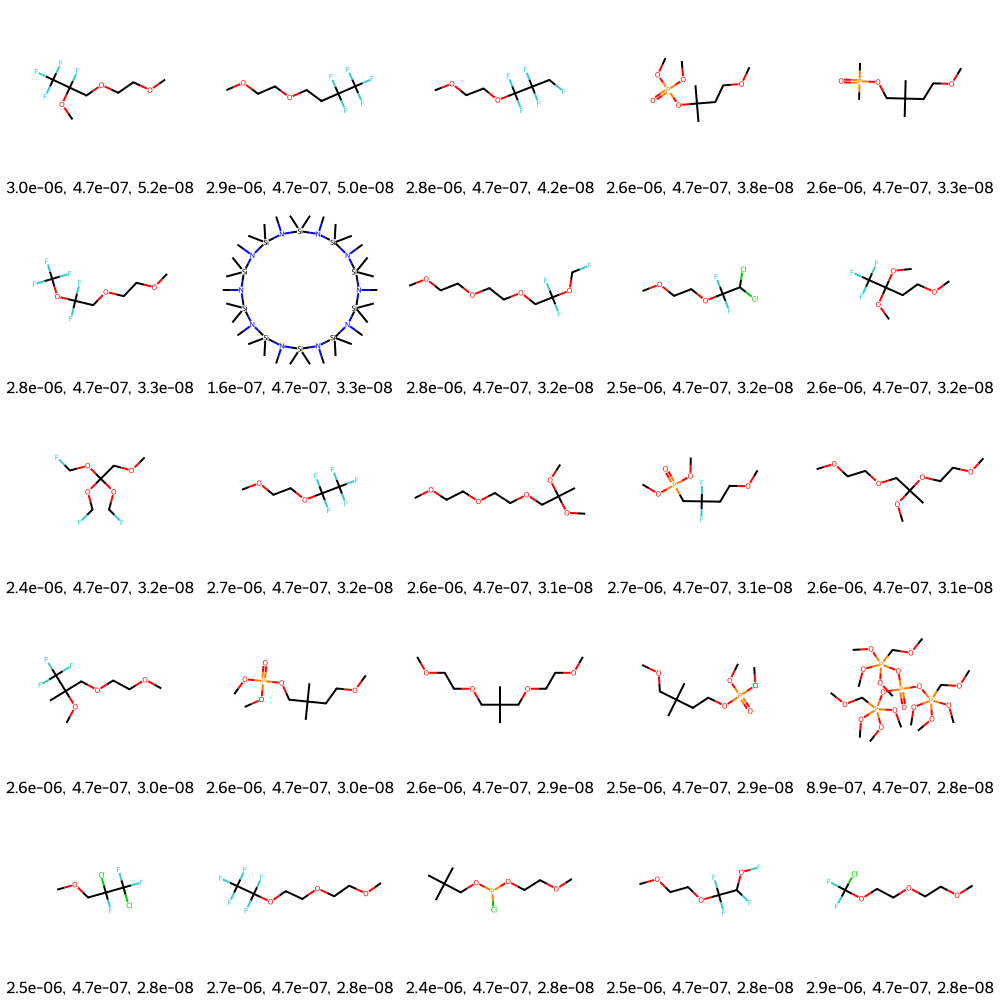

In [71]:
# df_new_['pred_uncertainty'] = df_new_.apply(lambda x: str(round(x['norm_capacity_3_pred'],3)) + ', ' + str(round(x['norm_capacity_3_uncer'],3)) + ', ' + str(round(x['EI_weight_av'],3)), axis=1)
df_new_['pred_comb'] = df_new_.apply(lambda x: str(format(x['norm_capacity_3_pred'],".1e")) + ', ' + str(format(x['norm_capacity_3_uncer'],".1e")) + ', ' + str(format(x['EI_aggr'],".1e")), axis=1)
PandasTools.AddMoleculeColumnToFrame(df_new_, smilesCol='solv_comb_sm')
# PandasTools.FrameToGridImage(df_, legendsCol="norm_capacity_3_pred", molsPerRow=6)
PandasTools.FrameToGridImage(df_new_.iloc[:25], legendsCol="pred_comb", molsPerRow=5)

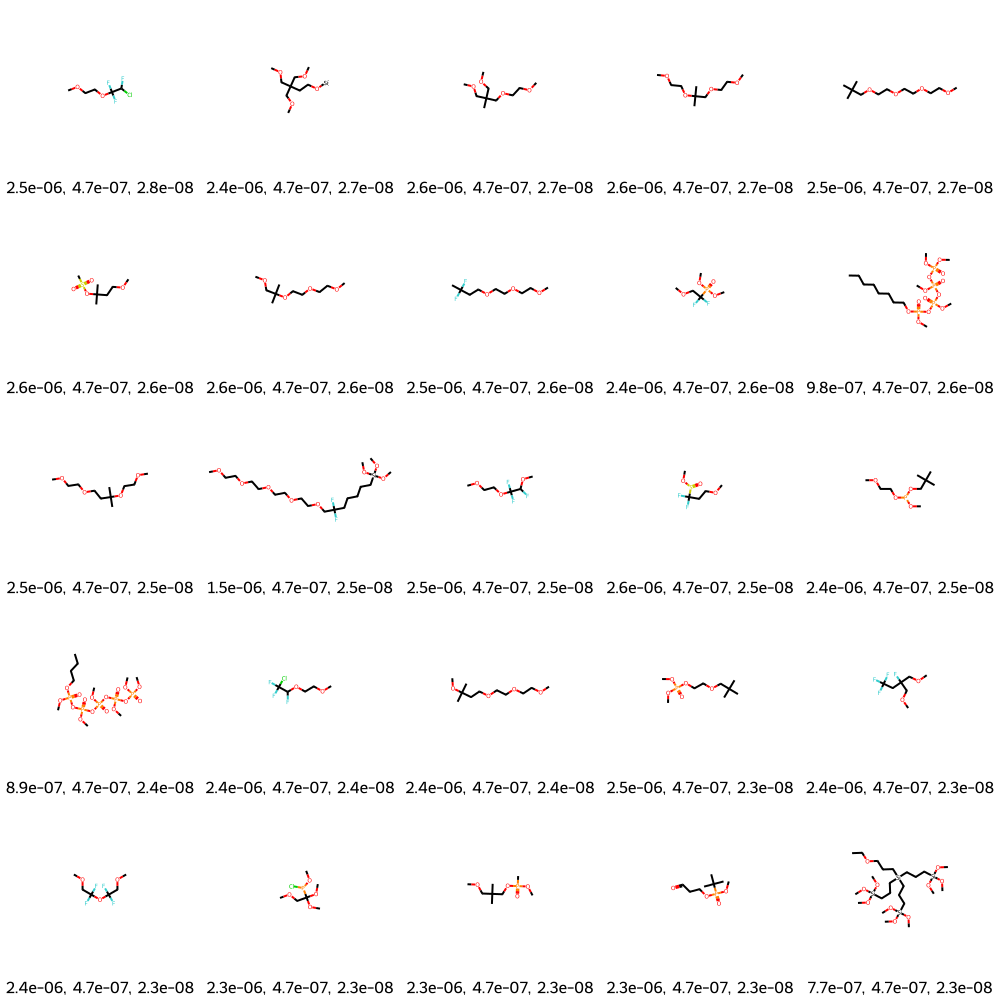

In [72]:
PandasTools.FrameToGridImage(df_new_.iloc[25:50], legendsCol="pred_comb", molsPerRow=5)

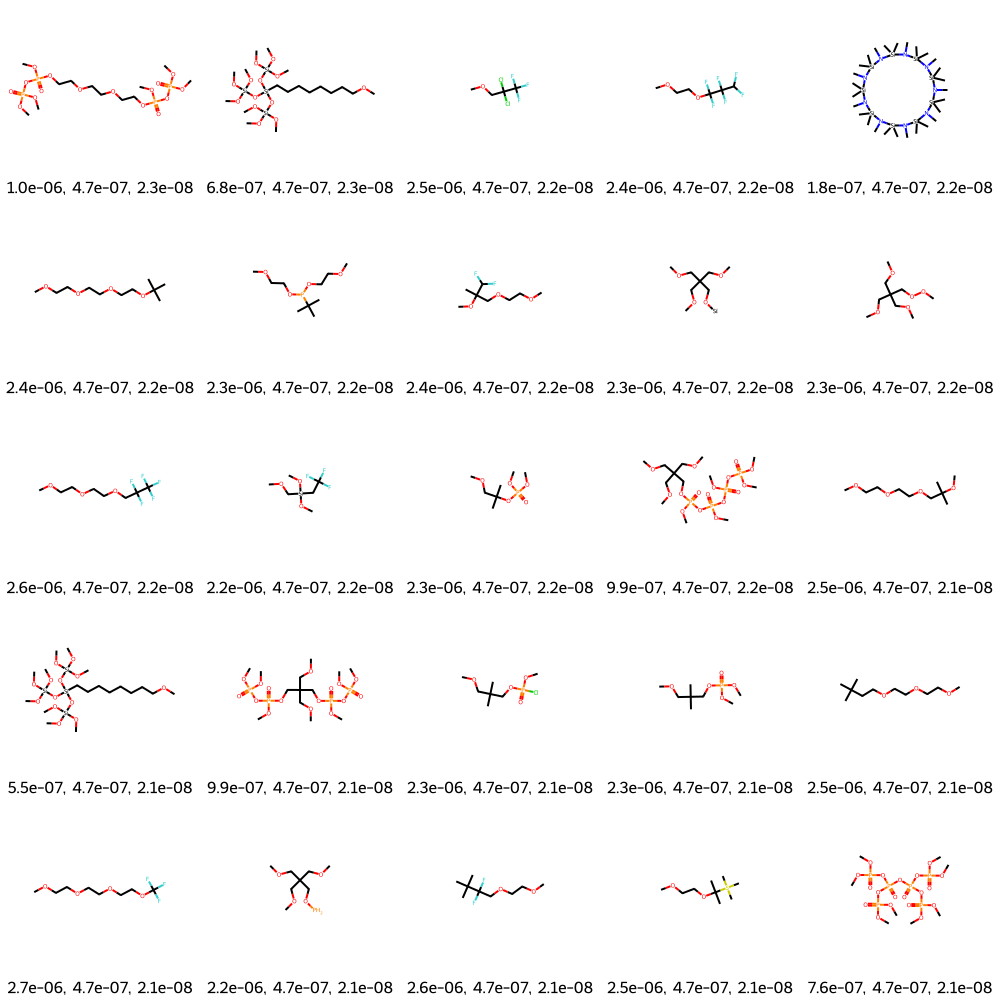

In [73]:
PandasTools.FrameToGridImage(df_new_.iloc[50:75], legendsCol="pred_comb", molsPerRow=5)

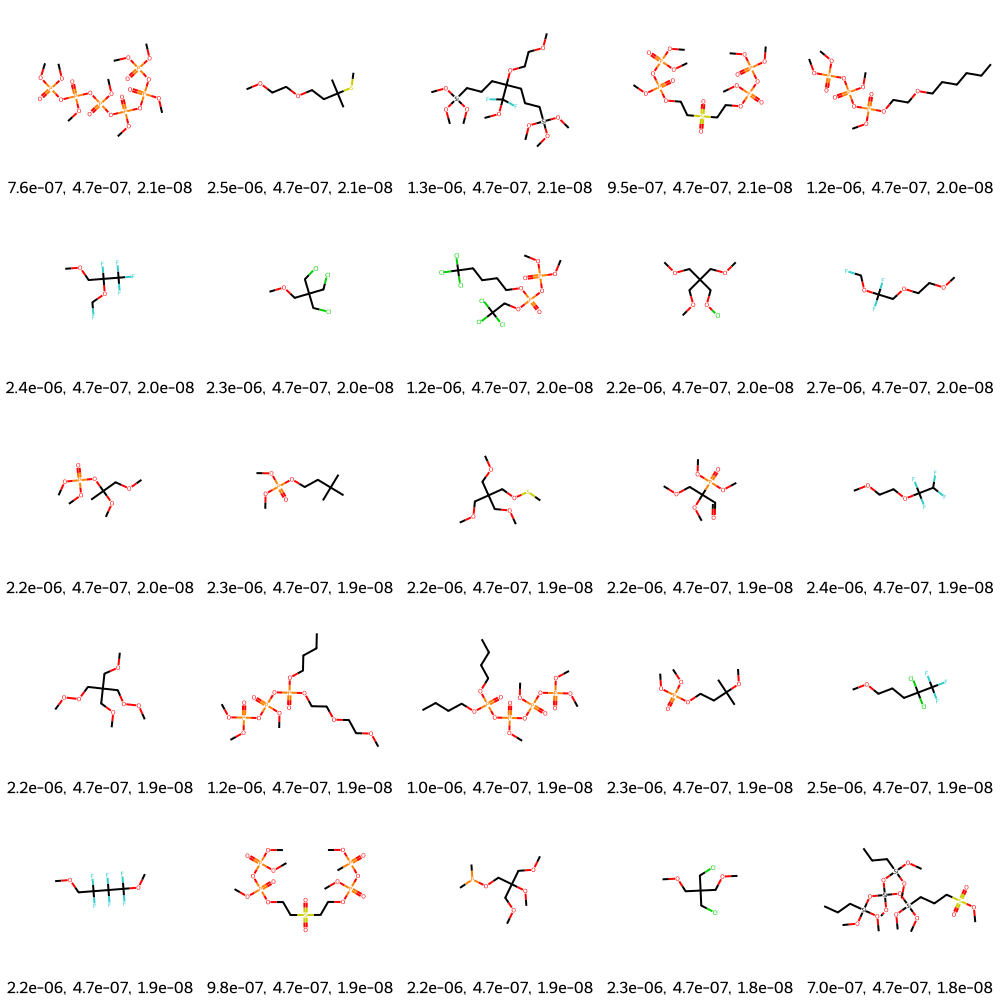

In [74]:
PandasTools.FrameToGridImage(df_new_.iloc[75:100], legendsCol="pred_comb", molsPerRow=5)

In [75]:
%%bash
ls -ltr

total 2580344
-rw-r--r--  1 riteshk  staff  506245881 Feb 18 15:29 unlabel_1mil_ecfp_pca_add_feat_iter_4.csv
-rw-r--r--@ 1 riteshk  staff       8270 Feb 18 15:29 just_label_iter_4.csv
-rw-r--r--@ 1 riteshk  staff     928738 Feb 18 15:48 Activelearning-batch3.xlsx
-rw-r--r--@ 1 riteshk  staff      57647 Feb 18 15:49 label_ecfp_pca_add_feat_iter_4_021824.csv
-rw-r--r--  1 riteshk  staff     169977 Feb 18 16:05 pairwise_iter4_021824.pkl
-rw-r--r--  1 riteshk  staff     169952 Feb 18 16:05 matern_iter4_021824.pkl
-rw-r--r--  1 riteshk  staff     170009 Feb 18 16:05 rq_iter4_021824.pkl
-rw-r--r--  1 riteshk  staff     170138 Feb 18 16:05 rbfexpsin_iter4_021824.pkl
-rw-r--r--  1 riteshk  staff  811173059 Feb 18 16:07 preds_uncer_ei_unlabel_1mil_iter4_021824.csv
-rw-r--r--@ 1 riteshk  staff    2018985 Feb 18 16:09 sugg_gpr_bma_iter_4.ipynb


**tSNE for top 10000**

In [77]:
df_new_10000 = df_new.iloc[:10000,:]
df_new_10000

,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,...,norm_capacity_3_un_matern,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr
223372,223382,223396,COCCOCC(F)(OC)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.020865,-1.124835,1.256503,-0.548366,0.183966,0.306774,...,0.177625,0.605769,0.115901,0.475044,0.154493,0.001473,0.002140,0.024827,0.000248,5.233567e-08
193873,193882,193894,COCCOCCC(F)(F)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.995461,-1.139384,1.208259,-0.557954,0.205390,0.322203,...,0.177487,0.601576,0.117923,0.462016,0.154082,0.001397,0.002024,0.024202,0.000185,5.001922e-08
168838,168846,168856,COCCOC(F)(F)C(F)(F)CF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.960369,-1.072072,1.171623,-0.571801,0.219191,0.145225,...,0.175920,0.590206,0.118405,0.414566,0.152378,0.000766,0.001089,0.020954,0.000058,4.160049e-08
132812,132819,132828,COCCC(C)(C)OP(=O)(OC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.975456,-1.159369,1.249466,-0.607173,0.318305,0.202041,...,0.178651,0.565602,0.142275,0.431674,0.155296,0.001071,0.001533,0.022196,0.000104,3.795455e-08
152611,152618,152628,COCCC(C)(C)COP(C)(C)=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.955890,-1.158321,1.217781,-0.601658,0.425932,0.161862,...,0.178021,0.555842,0.139410,0.434517,0.155059,0.000963,0.001375,0.018898,0.000109,3.311109e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290619,290629,290643,CCCC[Si](CCC)CCC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.421713,-1.867830,-0.194208,1.019533,0.208539,0.503873,...,0.206716,0.274110,0.207526,0.189498,0.181208,0.000094,0.000093,0.002619,0.000004,3.005802e-09
81676,81682,81688,COCCCCC1C(=O)N(C)C(=O)N(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.295490,-0.685801,1.035920,0.591494,-0.636765,0.488076,...,0.216936,0.174532,0.210156,0.336587,0.193941,0.001356,0.000507,0.000771,0.000168,3.005798e-09
133617,133624,133633,COCCC(OC)N1CCCC1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.141850,-0.553246,1.023952,0.293443,-0.937619,-0.587493,...,0.208683,0.233433,0.205782,0.325646,0.185046,0.000665,0.000515,0.001478,0.000083,3.005607e-09
313309,313320,313334,CCC(CC)(CN1CC(=O)OC(=O)C1)CN(CC(=O)OC)CC(C)(C)...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.159514,0.845333,1.077920,0.071798,0.858223,0.054981,...,0.333254,0.127037,0.256462,-0.007326,0.326118,0.000822,0.000791,0.001805,0.000349,3.005595e-09


In [80]:
df_new['norm_capacity_3_pred'].max()
# df_new_10000['solv_comb_sm'].unique().shape

2.9997276983727078e-06

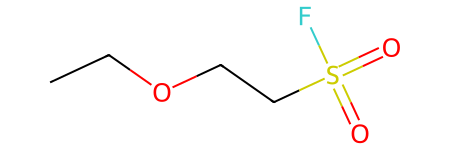

In [84]:
# Chem.MolFromSmiles('COC(C)C(C)(P(=O)(OC)OC)P(=O)(OC)OC')
# Chem.MolFromSmiles('COS(C)(OC)N(C)CC(C)(F)F')
Chem.MolFromSmiles('COCCCCC1C(=O)N(C)C(=O)N(C)C1=O')
Chem.MolFromSmiles('CCOCCS(=O)(=O)F')

In [ ]:
# df_unlabel_uniq_ = df_unlabel_.drop_duplicates(subset=['solv_comb_sm'], keep='first')
# df_unlabel_uniq_

In [82]:
df_comb_tsne = pd.read_csv('../comb_label_unlabel_tsne.csv') ## tsne plot all unique candidate solvent molecules (obtained from 1st iteration of AL)
df_comb_tsne

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1
0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,-0.377185,0.259444,...,-0.272648,73.052764,186.939685,1.0,0.0,150,50,2,16.453455,-31.206432
1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,0.018457,0.793475,...,-0.272648,114.079313,186.939685,1.0,0.0,150,50,2,-33.983090,12.215143
2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,-0.516489,0.217482,...,-0.272648,116.094963,186.939685,1.0,0.0,150,50,2,-4.163685,37.835484
3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,-0.311699,0.151570,...,-0.272648,70.058995,186.939685,1.0,0.0,150,50,2,24.099570,-31.178453
4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,-0.356929,0.299023,...,-0.272648,72.044939,186.939685,1.0,0.0,150,50,2,16.810526,-31.602932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388057,CCOCCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.793309,-1.253349,0.500190,0.218522,0.388077,0.105805,0.067019,0.165620,...,-0.272648,156.025643,186.939685,2.0,0.0,150,50,2,-27.724335,-20.865755
388058,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,-0.272648,111.999429,186.939685,1.0,0.0,150,50,2,-9.939236,35.545410
388059,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,-0.272648,111.999429,186.939685,2.0,0.0,150,50,2,-9.939236,35.545410
388060,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,-0.272648,111.999429,186.939685,4.0,0.0,203,50,1,-9.939253,35.545414


In [83]:
list_suggest_bool = df_comb_tsne['solv_comb_sm'].isin(df_new_10000['solv_comb_sm'])
sugg_ind = [i for i in range(len(list_suggest_bool)) if list_suggest_bool[i] == True]
list_label_pool = df_comb_tsne['solv_comb_sm'].isin(df['solv_comb_sm'])
label_ind = [i for i in range(len(list_label_pool)) if list_label_pool[i] == True]
# sugg_ind_1 = [sugg_ind[i] for i in range(int(len(sugg_ind)/2))]
# sugg_ind_2 = [sugg_ind[i] for i in range(int(len(sugg_ind)/2), len(sugg_ind))]
df_comb_tsne['database'] = 'unlabel'
# df_comb_tsne.loc[sugg_ind_1, 'database'] = 'sugg_4th_peiyuan'
# df_comb_tsne.loc[sugg_ind_2, 'database'] = 'sugg_4th_ritesh'
df_comb_tsne.loc[sugg_ind, 'database'] = 'sugg_all'
df_comb_tsne.loc[label_ind, 'database'] = 'label'
df_comb_tsne

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database
0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,-0.377185,0.259444,...,73.052764,186.939685,1.0,0.0,150,50,2,16.453455,-31.206432,unlabel
1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,0.018457,0.793475,...,114.079313,186.939685,1.0,0.0,150,50,2,-33.983090,12.215143,unlabel
2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,-0.516489,0.217482,...,116.094963,186.939685,1.0,0.0,150,50,2,-4.163685,37.835484,unlabel
3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,-0.311699,0.151570,...,70.058995,186.939685,1.0,0.0,150,50,2,24.099570,-31.178453,unlabel
4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,-0.356929,0.299023,...,72.044939,186.939685,1.0,0.0,150,50,2,16.810526,-31.602932,unlabel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388057,CCOCCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.793309,-1.253349,0.500190,0.218522,0.388077,0.105805,0.067019,0.165620,...,156.025643,186.939685,2.0,0.0,150,50,2,-27.724335,-20.865755,label
388058,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,1.0,0.0,150,50,2,-9.939236,35.545410,label
388059,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,2.0,0.0,150,50,2,-9.939236,35.545410,label
388060,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,4.0,0.0,203,50,1,-9.939253,35.545414,label


In [90]:
# df_comb_tsne.loc[df_comb_tsne['database'] == 'sugg_4th_ritesh']['solv_comb_sm'].unique().shape
df_comb_tsne.loc[df_comb_tsne['database'] == 'sugg_4th_peiyuan']
# df_comb_tsne.loc[df_comb_tsne['database'] == 'sugg_all']

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database


In [92]:
len(sugg_ind)
# sugg_ind
df_comb_tsne['database'].unique()

array(['unlabel', 'sugg_all', 'label'], dtype=object)

cluster regions rather than assigning randomly

In [85]:
df_comb_tsne_sugg = df_comb_tsne.loc[df_comb_tsne['database'] == 'sugg_all']
X_comb_tsne = df_comb_tsne_sugg.iloc[:,-3:-1]
X_comb_tsne

,TSNE_0,TSNE_1
133,-12.823354,-2.032009
242,0.000407,13.623653
251,-12.823583,-2.032158
410,32.329810,-5.278013
443,-24.336094,-11.264658
...,...,...
378068,28.356495,-27.317268
383977,38.663400,2.241377
384846,-33.897090,4.690404
385211,28.356192,-27.315676


In [86]:
kmeans = KMeans(random_state=0).fit(X_comb_tsne) ## using # of clusters found by kmeans method

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<AxesSubplot: xlabel='TSNE_0', ylabel='TSNE_1'>

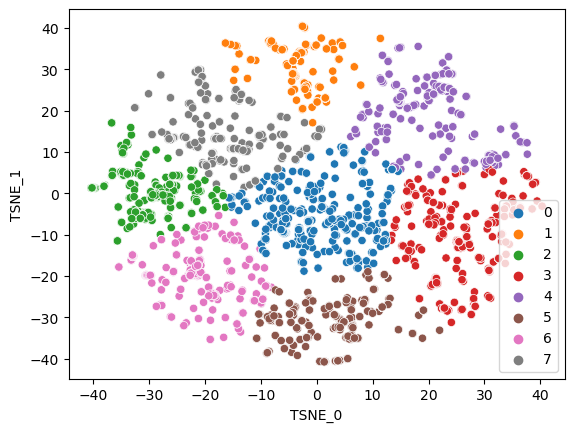

In [87]:
sns.scatterplot(x=df_comb_tsne_sugg['TSNE_0'], y=df_comb_tsne_sugg['TSNE_1'], hue=kmeans.labels_, palette='tab10')

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<AxesSubplot: xlabel='TSNE_0', ylabel='TSNE_1'>

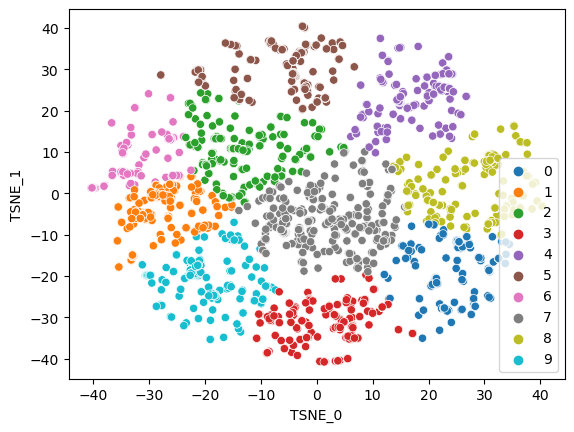

In [88]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_comb_tsne) ## fixing # of clusters to 10
sns.scatterplot(x=df_comb_tsne_sugg['TSNE_0'], y=df_comb_tsne_sugg['TSNE_1'], hue=kmeans.labels_, palette='tab10')

In [89]:
row_label = df_comb_tsne.loc[df_comb_tsne['database'] == 'label']
df_comb_tsne_sugg['database'] = [('sugg_4th_' + str(kmeans.labels_.astype(str)[i])) for i in range(len(kmeans.labels_))]
df_comb_tsne_ = pd.concat([row_label, df_comb_tsne_sugg], axis=0)
df_comb_tsne_

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_3705/604732410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comb_tsne_sugg['database'] = [('sugg_4th_' + str(kmeans.labels_.astype(str)[i])) for i in range(len(kmeans.labels_))]


,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database
2373,CN1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.389185,-0.935876,0.111029,0.485331,0.308117,-0.724181,0.398491,0.687894,...,99.104799,186.939685,1.0,0.0,150,50,2,26.357819,-1.480546,label
4139,CCN1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.876502,-1.072168,-0.081963,0.736596,0.206000,-0.486059,0.263508,0.370727,...,99.104799,186.939685,1.0,0.0,150,50,2,-27.672503,6.123165,label
6664,CCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.937292,-1.613544,0.672441,0.163123,-0.543020,0.617387,0.624449,0.415481,...,74.073165,186.939685,1.0,0.0,150,50,2,-14.375510,35.692364,label
7425,CCOCCCl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.761120,-1.609598,0.396423,0.137856,0.181540,0.205658,0.102161,0.166661,...,108.034193,186.939685,1.0,0.0,150,50,2,28.194572,-22.958084,label
20398,CC1(C)CCCC(=O)C1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.544321,-0.787394,0.681496,-0.289700,0.458624,0.255901,-0.920301,0.736245,...,126.104465,186.939685,1.0,0.0,150,50,2,6.669382,-13.322131,label
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378068,COCCOCCCCCCCCCCC[Si](OC)(OC)OC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.908149,-0.944494,0.971822,0.043047,-0.735702,0.985443,0.804811,0.287560,...,350.248851,144.001775,1.0,0.0,150,50,2,28.356495,-27.317268,sugg_4th_0
383977,CO[Si](OC)(OC)C([Si](OC)(OC)OC)([Si](OC)(OC)OC...,[Li+].O=C1O[B-](F)(F)OC1=O,-0.473794,-1.393888,1.066949,-0.607220,0.353716,-0.159430,0.584239,-0.017302,...,496.128383,144.001775,1.0,0.0,150,50,2,38.663400,2.241377,sugg_4th_8
384846,CCCCCCCCCCCCOCCOCCC[Si](OC)(OC)OC,[Li+].O=C1O[B-](F)(F)OC1=O,-1.076872,-1.681724,0.426816,1.007279,-0.740516,1.312715,0.261993,-0.277779,...,392.295801,144.001775,1.0,0.0,150,50,2,-33.897090,4.690404,sugg_4th_6
385211,COCCOCCCOCCCCCCCCCCC[Si](OC)(OC)OC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.915870,-0.938476,0.970829,0.044332,-0.738988,0.996804,0.802128,0.293352,...,408.290716,144.001775,1.0,0.0,150,50,2,28.356192,-27.315676,sugg_4th_0


In [144]:
df_new_10000.loc[df_new_10000['solv_comb_sm'] == 'COCCOCCCCCCCCCCC[Si](OC)(OC)OC']

,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,...,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr,rank
945033,945063,945101,COCCOCCCCCCCCCCC[Si](OC)(OC)OC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.908149,-0.944494,0.971822,0.043047,-0.735702,0.985443,...,0.101527,0.241821,0.239327,0.258149,0.001421,0.000979,0.000885,0.0006,3.499721e-09,7032


In [158]:
df_comb_tsne_.to_csv('iter_4_top10000_sugg_ei_unique_explore.csv')
# df_comb_tsne_ = pd.read_csv('iter_4_top10000_sugg_ei_unique_explore.csv')

In [150]:
df_new_10000['rank'] = [i for i in range(1,10001)]
df_comb_tsne_ = df_comb_tsne_.merge(df_new_10000[['solv_comb_sm', 'salt_comb_sm', 'rank']], on=['solv_comb_sm', 'salt_comb_sm'], how='left')
df_comb_tsne_

,Unnamed: 0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database,rank
0,2373,CN1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.389185,-0.935876,0.111029,0.485331,0.308117,-0.724181,0.398491,...,186.939685,1.0,0.0,150,50,2,26.357819,-1.480546,label,NaN
1,4139,CCN1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.876502,-1.072168,-0.081963,0.736596,0.206000,-0.486059,0.263508,...,186.939685,1.0,0.0,150,50,2,-27.672503,6.123165,label,NaN
2,6664,CCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.937292,-1.613544,0.672441,0.163123,-0.543020,0.617387,0.624449,...,186.939685,1.0,0.0,150,50,2,-14.375510,35.692364,label,NaN
3,7425,CCOCCCl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.761120,-1.609598,0.396423,0.137856,0.181540,0.205658,0.102161,...,186.939685,1.0,0.0,150,50,2,28.194572,-22.958084,label,NaN
4,20398,CC1(C)CCCC(=O)C1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.544321,-0.787394,0.681496,-0.289700,0.458624,0.255901,-0.920301,...,186.939685,1.0,0.0,150,50,2,6.669382,-13.322131,label,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8854,378068,COCCOCCCCCCCCCCC[Si](OC)(OC)OC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.908149,-0.944494,0.971822,0.043047,-0.735702,0.985443,0.804811,...,144.001775,1.0,0.0,150,50,2,28.356495,-27.317268,sugg_4th_0,7032.0
8855,383977,CO[Si](OC)(OC)C([Si](OC)(OC)OC)([Si](OC)(OC)OC...,[Li+].O=C1O[B-](F)(F)OC1=O,-0.473794,-1.393888,1.066949,-0.607220,0.353716,-0.159430,0.584239,...,144.001775,1.0,0.0,150,50,2,38.663400,2.241377,sugg_4th_8,4871.0
8856,384846,CCCCCCCCCCCCOCCOCCC[Si](OC)(OC)OC,[Li+].O=C1O[B-](F)(F)OC1=O,-1.076872,-1.681724,0.426816,1.007279,-0.740516,1.312715,0.261993,...,144.001775,1.0,0.0,150,50,2,-33.897090,4.690404,sugg_4th_6,1628.0
8857,385211,COCCOCCCOCCCCCCCCCCC[Si](OC)(OC)OC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.915870,-0.938476,0.970829,0.044332,-0.738988,0.996804,0.802128,...,144.001775,1.0,0.0,150,50,2,28.356192,-27.315676,sugg_4th_0,1700.0


In [153]:
df_comb_tsne['database'].unique()
df_comb_tsne_['database'].unique()
df_comb_tsne_.shape

(8859, 34)

Interactive tSNE plot (Himi's code)

In [156]:
## pick only rows for label, sugg_2nd_peiyuan, and sugg_2nd_ritesh -> not using it but rather clusters from kmeans
# df_comb_tsne__ = df_comb_tsne_.loc[df_comb_tsne['database'] != 'unlabel'] ## somehow this is not working
df_comb_tsne__ = df_comb_tsne_.copy()
df_comb_tsne__

,Unnamed: 0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database,rank
0,2373,CN1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.389185,-0.935876,0.111029,0.485331,0.308117,-0.724181,0.398491,...,186.939685,1.0,0.0,150,50,2,26.357819,-1.480546,label,NaN
1,4139,CCN1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.876502,-1.072168,-0.081963,0.736596,0.206000,-0.486059,0.263508,...,186.939685,1.0,0.0,150,50,2,-27.672503,6.123165,label,NaN
2,6664,CCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.937292,-1.613544,0.672441,0.163123,-0.543020,0.617387,0.624449,...,186.939685,1.0,0.0,150,50,2,-14.375510,35.692364,label,NaN
3,7425,CCOCCCl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.761120,-1.609598,0.396423,0.137856,0.181540,0.205658,0.102161,...,186.939685,1.0,0.0,150,50,2,28.194572,-22.958084,label,NaN
4,20398,CC1(C)CCCC(=O)C1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.544321,-0.787394,0.681496,-0.289700,0.458624,0.255901,-0.920301,...,186.939685,1.0,0.0,150,50,2,6.669382,-13.322131,label,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8854,378068,COCCOCCCCCCCCCCC[Si](OC)(OC)OC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.908149,-0.944494,0.971822,0.043047,-0.735702,0.985443,0.804811,...,144.001775,1.0,0.0,150,50,2,28.356495,-27.317268,sugg_4th_0,7032.0
8855,383977,CO[Si](OC)(OC)C([Si](OC)(OC)OC)([Si](OC)(OC)OC...,[Li+].O=C1O[B-](F)(F)OC1=O,-0.473794,-1.393888,1.066949,-0.607220,0.353716,-0.159430,0.584239,...,144.001775,1.0,0.0,150,50,2,38.663400,2.241377,sugg_4th_8,4871.0
8856,384846,CCCCCCCCCCCCOCCOCCC[Si](OC)(OC)OC,[Li+].O=C1O[B-](F)(F)OC1=O,-1.076872,-1.681724,0.426816,1.007279,-0.740516,1.312715,0.261993,...,144.001775,1.0,0.0,150,50,2,-33.897090,4.690404,sugg_4th_6,1628.0
8857,385211,COCCOCCCOCCCCCCCCCCC[Si](OC)(OC)OC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.915870,-0.938476,0.970829,0.044332,-0.738988,0.996804,0.802128,...,144.001775,1.0,0.0,150,50,2,28.356192,-27.315676,sugg_4th_0,1700.0


In [155]:
# df_comb_tsne__['database'].values.tolist()
df_comb_tsne__['database'].unique()

array(['sugg_4th_8', 'sugg_4th_3', 'sugg_4th_4', 'sugg_4th_0',
       'sugg_4th_5', 'sugg_4th_6', 'sugg_4th_2', 'sugg_4th_9',
       'sugg_4th_7', 'sugg_4th_1'], dtype=object)

In [157]:
def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc

def moltosvg(mol,molSize=(250,100),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return SVG(svg.replace('svg:',''))

PandasTools.AddMoleculeColumnToFrame(df_comb_tsne__,'solv_comb_sm', 'solv')

svgs_solv = [moltosvg(m).data for m in df_comb_tsne__.solv]
smile = df_comb_tsne__['solv_comb_sm'].values.tolist()
database_class = df_comb_tsne__['database'].values.tolist()
ind = df_comb_tsne__.index.values.tolist()
rank = df_comb_tsne__['rank'].values.tolist()
ChangeMoleculeRendering(renderer='PNG')

# source = ColumnDataSource(data=dict(x=df_comb_tsne__['TSNE_0'], y=df_comb_tsne__['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, color_column_name=df_comb_tsne__['database']))
source = ColumnDataSource(data=dict(x=df_comb_tsne__['TSNE_0'], y=df_comb_tsne__['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, ind=ind, rank=rank, color=df_comb_tsne__['database'].map({'sugg_4th_0':'cyan', 'sugg_4th_1':'orange', 'sugg_4th_2':'gray',
                                                                                                                                                                                       'sugg_4th_3':'teal', 'sugg_4th_4':'green', 'sugg_4th_5':'yellow', 
                                                                                                                                                                                       'sugg_4th_6':'red', 'sugg_4th_7':'purple', 'sugg_4th_8':'lime',
                                                                                                                                                                                       'sugg_4th_9':'magenta', 'label':'blue'})))

hover = HoverTool(tooltips="""
    <div>
        <div> 
            <span style="font-size: 12px; font-weight: bold;"> @svgs_solv{safe} </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> SMILES: @smile </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Class: @desc </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Rank: @rank </span>
        </div>
    </div>
    """
)

interactive_map = figure(width=1000, height=1000, tools=['reset,box_zoom,wheel_zoom,zoom_in,zoom_out,pan',hover])
interactive_map.title.text = "Suggestions from AL (iteration-4; Top 10000 from model)"
interactive_map.title.align = "center"
interactive_map.title.text_color = "orange"
interactive_map.title.text_font_size = "25px"

# palette = d3['Category10'][len(df_comb_tsne['database'].unique())]
# color_map = CategoricalColorMapper(factors=df_comb_tsne['database'].unique(),
#                                    palette=palette)
# # interactive_map.circle('x', 'y', hue=, size=6, source=source, fill_alpha=0.2)
# # interactive_map.circle('x', 'y', line_color=mapper, color=mapper, size=6, source=source, fill_alpha=0.2)
# # color_bar = ColorBar(color_mapper=mapper['transform'], width=8)
# # interactive_map.add_layout(color_bar, 'right')
interactive_map.scatter('x', 'y', 
                        # color={'field': df_comb_tsne_['database'], 'transform': color_map},
                        color = 'color',
                        # legend='top_right', ## does not work
                        source=source, size=7, fill_alpha=0.8)
output_file("interactive_map_sugg_al_021824_explore.html")
save(interactive_map)

'/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/AL-CE/08-22-23/campaign-4/interactive_map_sugg_al_021824_explore.html'

In [127]:
# me_1 = df_comb_tsne__.loc[df_comb_tsne__['database'] == 'sugg_3rd_0'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
# me_2 = df_comb_tsne__.loc[df_comb_tsne__['database'] == 'sugg_3rd_1'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
# me_3 = df_comb_tsne__.loc[df_comb_tsne__['database'] == 'sugg_3rd_2'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
# me_4 = df_comb_tsne__.loc[df_comb_tsne__['database'] == 'sugg_3rd_3'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
# to_me = pd.concat([me_1, me_2, me_3, me_4], axis=0)
# to_me

,solv_comb_sm,TSNE_0,TSNE_1,database
3004,CO[Si](CCCCN(C)C(=O)N(C(=O)N(C)C)C(=O)N(C)CCCC...,8.165010,19.118220,sugg_3rd_0
3438,CO[Si](CCCN(C)C(=O)N(C(=O)N(C)C)C(=O)N(C)CCC[S...,8.188257,19.169886,sugg_3rd_0
4001,CCO[Si](CCCN(C)C(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(...,-1.791855,10.948774,sugg_3rd_0
4810,CO[Si](CCCN(C)C(=O)N(C)C)(OC)OC[Si](OC)(OC)OCC...,8.283033,18.338127,sugg_3rd_0
9573,CO[Si](CCCN(C)C(=O)N(CCC[Si](OC)(OC)OC)C(=O)N(...,8.206909,19.229433,sugg_3rd_0
...,...,...,...,...
367467,CCCCC(CCCN(C)C)(CN(C)C)C(CCCC)(CCCC)[Si](OC)(O...,12.724574,-26.861282,sugg_3rd_3
367535,COCCN1CCN(CCCN(C)C(=O)CN(C)C(=O)CN(C)C(=O)CN(C...,2.222466,-27.310150,sugg_3rd_3
368750,CO[Si](C)(CCCSSCCC[Si](C)(OC)OCCN(C)C)OCCN(C)C,-4.948080,-26.543440,sugg_3rd_3
369248,COC(COCCC[Si](OC)(OC)OC)CN(C)CCC[Si](OC)(OC)OC,-9.675708,-25.567408,sugg_3rd_3


In [128]:
# peiyuan_1 = df_comb_tsne__.loc[df_comb_tsne__['database'] == 'sugg_3rd_4'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
# peiyuan_2 = df_comb_tsne__.loc[df_comb_tsne__['database'] == 'sugg_3rd_5'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
# peiyuan_3 = df_comb_tsne__.loc[df_comb_tsne__['database'] == 'sugg_3rd_6'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
# peiyuan_4 = df_comb_tsne__.loc[df_comb_tsne__['database'] == 'sugg_3rd_7'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
# to_peiyuan = pd.concat([peiyuan_1, peiyuan_2, peiyuan_3, peiyuan_4], axis=0)
# to_peiyuan

,solv_comb_sm,TSNE_0,TSNE_1,database
817,CO[Si](CCCN(C)C(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,20.163671,-7.315735,sugg_3rd_4
872,CO[Si](CCCN(C)C(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,20.788770,-7.305290,sugg_3rd_4
1545,CO[Si](CCCN(C)C(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,20.163263,-7.315250,sugg_3rd_4
2106,COC(=O)C(F)(F)C(F)(F)C(F)(F)C(=O)N(C)CCC[Si](O...,20.669907,-7.487590,sugg_3rd_4
3949,CCOCCO[Al],28.191956,-22.931060,sugg_3rd_4
...,...,...,...,...
368723,COC(=O)CN(C)C(=O)CN(C(=O)CCCCCN(C)C)C(=O)CN(C)...,-6.617611,34.803616,sugg_3rd_7
369955,COC(=O)CN(C)C(=O)CN(C)C(=O)CN(C(=O)CCCCCN(C)C)...,-6.617611,34.803616,sugg_3rd_7
371063,COCCCN(C(=O)CN(C)C(=O)CN(C)C(=O)CN(C)C(=O)CN(C...,0.795252,37.594420,sugg_3rd_7
371231,COC(=O)CN(CC(=O)N(C)C)C(=O)CCCCCN(C)C(C)=O,-6.725861,34.727512,sugg_3rd_7


In [130]:
# to_me.to_csv('top5000_1_sugg_list_me_4th.csv')
# to_peiyuan.to_csv('top5000_2_sugg_list_peiyuan_4th.csv')

In [ ]:
# df_new_5000_uniq = df_new_5000.drop_duplicates(subset=['solv_comb_sm'], keep='first')
# df_new_5000_uniq

In [23]:
## somehow the lengths of dataframes obtained using code is not matching with the one above
# df_new_5000_uniq = df_comb_tsne.loc[df_comb_tsne['database'] == 'suggestions_EI']
# # df_new_5000_uniq.to_csv('top5000_sugg_ei_iter2_101723.csv') ## saving top 5000 suggestions for 2nd iteration of AL (actual number of solvent lower)
# len_df_5000_uniq = len(df_new_5000_uniq)
# to_peiyuan = df_new_5000_uniq.iloc[:int(len_df_5000_uniq/2),:]
# to_me = df_new_5000_uniq.iloc[int(len_df_5000_uniq/2):,:]
# to_me

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database
233439,COCC(C)(N(C)C)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.904553,-1.002129,0.121740,-1.208398,0.522855,0.256292,1.277224,0.357924,...,160.157563,186.939685,1.0,0.0,150,50,2,-16.795280,3.238802,suggestions_EI
233484,COC(C(C)(C)C)C(C)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.831971,-1.447336,0.910930,-0.952117,0.393250,-0.761451,0.887642,-0.329430,...,166.116922,186.939685,1.0,0.0,150,50,2,-23.715467,-18.477345,suggestions_EI
233552,COC(N(C)N(C)C)C(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.895380,-0.916755,-0.113074,-1.335874,0.350350,-0.339785,0.930612,0.156978,...,174.173213,186.939685,1.0,0.0,150,50,2,-13.113187,4.985058,suggestions_EI
233654,COCC(C)(CN(C)Cl)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.874006,-1.026230,0.187408,-1.242342,0.667451,0.277439,1.343890,0.324395,...,181.086956,186.939685,1.0,0.0,150,50,2,-16.818485,3.239529,suggestions_EI
234157,CCC(OC)OC(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.133694,-1.390515,0.514080,-0.502895,0.013895,-0.583223,0.729658,-0.462661,...,146.130680,186.939685,1.0,0.0,150,50,2,-3.061893,9.384779,suggestions_EI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385211,COCCOCCCOCCCCCCCCCCC[Si](OC)(OC)OC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.915870,-0.938476,0.970829,0.044332,-0.738988,0.996804,0.802128,0.293352,...,408.290716,144.001775,1.0,0.0,150,50,2,28.356192,-27.315676,suggestions_EI
385897,CO[Si](CCC(CC[Si](OC)(OC)OC)CC[Si](OC)(OC)OC)(...,[Li+].O=C1O[B-](F)(F)OC1=O,-0.784803,-1.203755,0.512146,-0.385240,-0.676515,-0.570004,0.204125,-0.038398,...,460.198012,144.001775,1.0,0.0,150,50,2,-22.544157,-29.767284,suggestions_EI
385908,COCCC(OC)N(C)C(C)(C)C,[Li+].O=C1O[B-](F)(F)OC1=O,-1.204121,-0.980336,-0.080584,-1.088509,-0.349281,-0.071455,1.546685,0.465116,...,189.172879,144.001775,1.0,0.0,150,50,2,-13.031423,4.894910,suggestions_EI
386563,CO[Si](CCCCC(CCC[Si](OC)(OC)OC)C(C)(C)CC(C)(C)...,[Li+].O=C1O[B-](F)(F)OC1=O,-1.114709,-1.313834,0.572373,-0.257871,-0.122796,-0.486306,0.851936,-0.298315,...,466.314592,144.001775,1.0,0.0,150,50,2,-6.417870,-8.757124,suggestions_EI


In [107]:
## find duplicates in df_new_5000
# df_comb_tsne.loc[df_comb_tsne['solv_comb_sm'] == 'COC(C)C(C)(P(=O)(OC)OC)P(=O)(OC)OC']

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database
95568,COC(C)C(C)(P(=O)(OC)OC)P(=O)(OC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.996998,-1.066859,0.908817,-0.811778,-0.075786,-1.036721,0.652884,-0.237597,...,304.084076,186.939685,1.0,0.0,150,50,2,15.454866,-12.748531,suggestions_EI


**Finding from top 10000 predictions**

In [99]:
df_exploit = df_unlabel_.copy()
df_exploit['norm_capacity_3_avg_pred'] = df_exploit[['norm_capacity_3_pair', 'norm_capacity_3_matern', 'norm_capacity_3_rq', 'norm_capacity_3_rbfexpsin']].mean(axis=1)
df_exploit_10000 = df_exploit.sort_values(by=['norm_capacity_3_avg_pred'], ascending=False).iloc[:10000,:]
df_exploit_10000

,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,...,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr,norm_capacity_3_avg_pred
223372,223382,223396,COCCOCC(F)(OC)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.020865,-1.124835,1.256503,-0.548366,0.183966,0.306774,...,0.605769,0.115901,0.475044,0.154493,0.001473,0.002140,0.024827,0.000248,5.233567e-08,0.501407
193873,193882,193894,COCCOCCC(F)(F)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.995461,-1.139384,1.208259,-0.557954,0.205390,0.322203,...,0.601576,0.117923,0.462016,0.154082,0.001397,0.002024,0.024202,0.000185,5.001922e-08,0.495234
260312,260322,260336,COCCOCCOCC(F)(F)OCF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.979777,-1.126940,1.238547,-0.543210,0.172293,0.267553,...,0.555848,0.129911,0.478356,0.154863,0.001604,0.002138,0.016054,0.000271,3.247244e-08,0.491009
241085,241095,241109,COCCOCC(F)(F)OC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.968319,-1.135495,1.227771,-0.554208,0.147720,0.283525,...,0.561961,0.124559,0.469612,0.154127,0.001518,0.002062,0.015812,0.000217,3.294938e-08,0.489186
330430,330441,330455,COCCCC(Cl)(Cl)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.037912,-1.653221,1.019062,-0.386838,0.013395,0.421732,...,0.451989,0.165424,0.500525,0.158103,0.002504,0.002889,0.008479,0.000498,1.874720e-08,0.481620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,32578,32581,COC(=O)CCOP(=O)(OC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.322757,0.281139,1.629872,0.048495,-0.078204,0.285749,...,0.184661,0.208520,0.333339,0.182628,0.000657,0.000368,0.000836,0.000083,2.134644e-09,0.286275
73624,73629,73635,CCOP(CCCP(=O)(OCC)OCC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.970541,-1.103547,0.661965,0.394851,0.010532,0.373956,...,0.192922,0.194681,0.320969,0.174799,0.000614,0.000239,0.000550,0.000038,1.646808e-09,0.286272
308725,308736,308750,O=C(F)OCCCOC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.225757,-0.374531,1.139201,0.353346,0.962574,0.065242,...,0.197635,0.199384,0.333800,0.175691,0.000454,0.000278,0.000714,0.000053,1.698690e-09,0.286270
133816,133823,133832,CCOC(COP(=O)(OC)OC)OCC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.069335,-1.093042,0.660851,-0.069901,-0.481866,-0.214157,...,0.263372,0.183022,0.289669,0.164539,0.000241,0.000171,0.001017,0.000008,1.733480e-09,0.286257


In [111]:
# df_exploit_10000.loc[df_exploit_10000['solv_comb_sm'] == 'COCCOF']

,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,...,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr,norm_capacity_3_avg_pred
427,427,427,COCCOF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.863536,-1.039067,1.081461,-0.406529,-0.227115,0.260969,...,0.295248,0.12857,0.342038,0.157055,0.000353,0.000239,0.000092,0.000015,9.103795e-10,0.328152


In [100]:
df_tsne_exploit = pd.read_csv('../comb_label_unlabel_tsne.csv') ## tsne plot all unique candidate solvent molecules (obtained from 1st iteration of AL)
list_exploit_bool = df_tsne_exploit['solv_comb_sm'].isin(df_exploit_10000['solv_comb_sm'])
exploit_ind = [i for i in range(len(list_exploit_bool)) if list_exploit_bool[i] == True]
list_label_pool = df_tsne_exploit['solv_comb_sm'].isin(df['solv_comb_sm'])
label_ind = [i for i in range(len(list_label_pool)) if list_label_pool[i] == True]
df_tsne_exploit['database'] = 'unlabel'
df_tsne_exploit.loc[exploit_ind, 'database'] = 'exploit'
df_tsne_exploit.loc[label_ind, 'database'] = 'label'
df_tsne_exploit

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database
0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,-0.377185,0.259444,...,73.052764,186.939685,1.0,0.0,150,50,2,16.453455,-31.206432,unlabel
1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,0.018457,0.793475,...,114.079313,186.939685,1.0,0.0,150,50,2,-33.983090,12.215143,unlabel
2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,-0.516489,0.217482,...,116.094963,186.939685,1.0,0.0,150,50,2,-4.163685,37.835484,unlabel
3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,-0.311699,0.151570,...,70.058995,186.939685,1.0,0.0,150,50,2,24.099570,-31.178453,unlabel
4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,-0.356929,0.299023,...,72.044939,186.939685,1.0,0.0,150,50,2,16.810526,-31.602932,unlabel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388057,CCOCCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.793309,-1.253349,0.500190,0.218522,0.388077,0.105805,0.067019,0.165620,...,156.025643,186.939685,2.0,0.0,150,50,2,-27.724335,-20.865755,label
388058,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,1.0,0.0,150,50,2,-9.939236,35.545410,label
388059,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,2.0,0.0,150,50,2,-9.939236,35.545410,label
388060,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,4.0,0.0,203,50,1,-9.939253,35.545414,label


/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<AxesSubplot: xlabel='TSNE_0', ylabel='TSNE_1'>

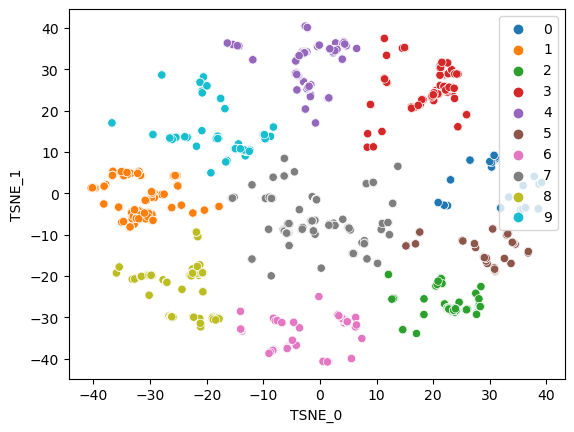

In [103]:
df_tsne_exploit_sugg = df_tsne_exploit.loc[df_tsne_exploit['database'] == 'exploit']
X_tsne_exploit = df_tsne_exploit_sugg.iloc[:,-3:-1]
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_tsne_exploit) ## using # of clusters found by kmeans method
sns.scatterplot(x=df_tsne_exploit_sugg['TSNE_0'], y=df_tsne_exploit_sugg['TSNE_1'], hue=kmeans.labels_, palette='tab10')

In [112]:
# df_tsne_exploit_sugg['norm_capacity_3_avg_pred'] = df_exploit_10000['norm_capacity_3_avg_pred']
df_tsne_exploit_sugg = df_tsne_exploit_sugg.merge(df_exploit_10000[['solv_comb_sm', 'norm_capacity_3_avg_pred']], on='solv_comb_sm', how='left')
df_tsne_exploit_sugg

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database,norm_capacity_3_avg_pred
0,COP(=O)(OC)OP,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.562406,-1.128913,1.184731,-0.439677,-0.025809,-0.102259,0.229179,0.346099,...,186.939685,1.0,0.0,150,50,2,30.916122,-18.803947,exploit_5,0.294753
1,COCCOF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.863536,-1.039067,1.081461,-0.406529,-0.227115,0.260969,0.755056,0.576431,...,186.939685,1.0,0.0,150,50,2,20.200350,24.282938,exploit_3,0.328152
2,COP(C)(=O)O[AlH2],[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.603479,-1.143439,1.165883,-0.352102,0.087478,-0.056811,0.257733,0.317275,...,186.939685,1.0,0.0,150,50,2,-8.869445,-38.642567,exploit_6,0.289585
3,COP(=O)(P)OP,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.533840,-1.115119,1.176279,-0.414674,-0.057984,-0.106595,0.212265,0.303192,...,186.939685,1.0,0.0,150,50,2,30.914911,-18.829397,exploit_5,0.293445
4,CCOP(=O)(OC)OCF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.793303,-1.087016,0.856013,-0.032545,0.060729,0.214266,0.173546,0.121674,...,186.939685,1.0,0.0,150,50,2,4.459742,35.893550,exploit_4,0.288667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,CC(C)(C)OOCCOP(C)(=O)OCCOOC(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.650043,-1.166241,0.806092,-0.341919,0.838693,-0.121705,1.043589,0.024049,...,186.939685,1.0,0.0,150,50,2,-33.545383,-8.116321,exploit_1,0.292023
9996,CCCCCOP(=O)(Cl)C(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.409437,-1.577940,0.031570,1.019297,-0.528638,0.012904,-0.195872,-0.190480,...,186.939685,1.0,0.0,150,50,2,-9.819498,14.221310,exploit_9,0.296518
9997,CCOC(=O)C(C=O)(CC)CCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.601342,-0.136380,1.213411,0.494598,0.321291,0.614563,0.790750,0.080714,...,186.939685,1.0,0.0,150,50,2,23.694480,25.443440,exploit_3,0.319584
9998,COC(=O)CCCOCCOCCCl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.223999,0.305796,1.436115,0.381743,-0.139809,0.737494,0.079509,0.068249,...,186.939685,1.0,0.0,150,50,2,-19.962057,26.036640,exploit_9,0.297637


In [113]:
row_label = df_tsne_exploit.loc[df_tsne_exploit['database'] == 'label']
df_tsne_exploit_sugg['database'] = [('exploit_' + str(kmeans.labels_.astype(str)[i])) for i in range(len(kmeans.labels_))]
df_tsne_exploit_ = pd.concat([row_label, df_tsne_exploit_sugg], axis=0)
df_tsne_exploit_

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database,norm_capacity_3_avg_pred
2373,CN1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.389185,-0.935876,0.111029,0.485331,0.308117,-0.724181,0.398491,0.687894,...,186.939685,1.0,0.0,150,50,2,26.357819,-1.480546,label,NaN
4139,CCN1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.876502,-1.072168,-0.081963,0.736596,0.206000,-0.486059,0.263508,0.370727,...,186.939685,1.0,0.0,150,50,2,-27.672503,6.123165,label,NaN
6664,CCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.937292,-1.613544,0.672441,0.163123,-0.543020,0.617387,0.624449,0.415481,...,186.939685,1.0,0.0,150,50,2,-14.375510,35.692364,label,NaN
7425,CCOCCCl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.761120,-1.609598,0.396423,0.137856,0.181540,0.205658,0.102161,0.166661,...,186.939685,1.0,0.0,150,50,2,28.194572,-22.958084,label,NaN
20398,CC1(C)CCCC(=O)C1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.544321,-0.787394,0.681496,-0.289700,0.458624,0.255901,-0.920301,0.736245,...,186.939685,1.0,0.0,150,50,2,6.669382,-13.322131,label,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,CC(C)(C)OOCCOP(C)(=O)OCCOOC(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.650043,-1.166241,0.806092,-0.341919,0.838693,-0.121705,1.043589,0.024049,...,186.939685,1.0,0.0,150,50,2,-33.545383,-8.116321,exploit_1,0.292023
9996,CCCCCOP(=O)(Cl)C(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.409437,-1.577940,0.031570,1.019297,-0.528638,0.012904,-0.195872,-0.190480,...,186.939685,1.0,0.0,150,50,2,-9.819498,14.221310,exploit_9,0.296518
9997,CCOC(=O)C(C=O)(CC)CCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.601342,-0.136380,1.213411,0.494598,0.321291,0.614563,0.790750,0.080714,...,186.939685,1.0,0.0,150,50,2,23.694480,25.443440,exploit_3,0.319584
9998,COC(=O)CCCOCCOCCCl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.223999,0.305796,1.436115,0.381743,-0.139809,0.737494,0.079509,0.068249,...,186.939685,1.0,0.0,150,50,2,-19.962057,26.036640,exploit_9,0.297637


In [114]:
df_tsne_exploit_['norm_capacity_3_avg_pred']

2373          NaN
4139          NaN
6664          NaN
7425          NaN
20398         NaN
           ...   
9995     0.292023
9996     0.296518
9997     0.319584
9998     0.297637
9999     0.355744
Name: norm_capacity_3_avg_pred, Length: 10110, dtype: float64

In [115]:
df_tsne_exploit_.to_csv('iter_4_top10000_sugg_ei_unique_exploit.csv')

In [128]:
def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc

def moltosvg(mol,molSize=(250,100),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return SVG(svg.replace('svg:',''))

PandasTools.AddMoleculeColumnToFrame(df_tsne_exploit_,'solv_comb_sm', 'solv')

svgs_solv = [moltosvg(m).data for m in df_tsne_exploit_.solv]
smile = df_tsne_exploit_['solv_comb_sm'].values.tolist()
database_class = df_tsne_exploit_['database'].values.tolist()
ind = df_tsne_exploit_.index.values.tolist()
pred = ([0.0]*110) + [round(val, 3) for val in df_tsne_exploit_['norm_capacity_3_avg_pred'].iloc[110:].values.tolist()]
ChangeMoleculeRendering(renderer='PNG')

# source = ColumnDataSource(data=dict(x=df_comb_tsne__['TSNE_0'], y=df_comb_tsne__['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, color_column_name=df_comb_tsne__['database']))
source = ColumnDataSource(data=dict(x=df_tsne_exploit_['TSNE_0'], y=df_tsne_exploit_['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, ind=ind, pred=pred, color=df_tsne_exploit_['database'].map({'exploit_0':'cyan', 'exploit_1':'orange', 'exploit_2':'gray',
                                                                                                                                                                                       'exploit_3':'teal', 'exploit_4':'green', 'exploit_5':'yellow', 
                                                                                                                                                                                       'exploit_6':'red', 'exploit_7':'purple', 'exploit_8':'lime',
                                                                                                                                                                                       'exploit_9':'magenta', 'label':'blue'})))

hover = HoverTool(tooltips="""
    <div>
        <div> 
            <span style="font-size: 12px; font-weight: bold;"> @svgs_solv{safe} </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> SMILES: @smile </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Class: @desc </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Prediction: @pred </span>
        </div>
    </div>
    """
)

interactive_map = figure(width=1000, height=1000, tools=['reset,box_zoom,wheel_zoom,zoom_in,zoom_out,pan',hover])
interactive_map.title.text = "Suggestions from AL (iteration-4; Top 10000 predictions)"
interactive_map.title.align = "center"
interactive_map.title.text_color = "orange"
interactive_map.title.text_font_size = "25px"

# palette = d3['Category10'][len(df_comb_tsne['database'].unique())]
# color_map = CategoricalColorMapper(factors=df_comb_tsne['database'].unique(),
#                                    palette=palette)
# # interactive_map.circle('x', 'y', hue=, size=6, source=source, fill_alpha=0.2)
# # interactive_map.circle('x', 'y', line_color=mapper, color=mapper, size=6, source=source, fill_alpha=0.2)
# # color_bar = ColorBar(color_mapper=mapper['transform'], width=8)
# # interactive_map.add_layout(color_bar, 'right')
interactive_map.scatter('x', 'y', 
                        # color={'field': df_comb_tsne_['database'], 'transform': color_map},
                        color = 'color',
                        # legend='top_right', ## does not work
                        source=source, size=7, fill_alpha=0.8)
output_file("interactive_map_sugg_al_021824_exploit.html")
save(interactive_map)

'/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/AL-CE/08-22-23/campaign-4/interactive_map_sugg_al_021824_exploit.html'

In [155]:
# me_1_ = df_comb_tsne_n.loc[df_comb_tsne_n['database'] == 'next_5000_0'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
# me_2_ = df_comb_tsne_n.loc[df_comb_tsne_n['database'] == 'next_5000_1'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
# me_3_ = df_comb_tsne_n.loc[df_comb_tsne_n['database'] == 'next_5000_2'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
# me_4_ = df_comb_tsne_n.loc[df_comb_tsne_n['database'] == 'next_5000_3'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
# to_me_ = pd.concat([me_1_, me_2_, me_3_, me_4_], axis=0)
# to_me_

,solv_comb_sm,TSNE_0,TSNE_1,database
817,CO[Si](CCCN(C)C(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,20.163671,-7.315735,next_5000_0
872,CO[Si](CCCN(C)C(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,20.788770,-7.305290,next_5000_0
6297,COCCOCN(C)C(=O)N(C)C,14.198602,-16.244967,next_5000_0
6428,CO[Si](CN(C)C(=O)OCC(F)(F)C(F)(F)C(F)(F)C(F)(F...,21.450367,-5.636488,next_5000_0
6750,CCCCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)[Si](O...,21.385866,-20.548735,next_5000_0
...,...,...,...,...
377873,COCCOCCCO[Si]CCCN(C)C,-18.868317,8.314200,next_5000_3
383934,COCCCCOCCOCCN(C)C,-18.820211,8.336507,next_5000_3
384943,COCCOCCCN(C)S(C)(=O)=O,-18.929428,8.309828,next_5000_3
385575,COCCOCCCCOCCCN(C)C,-18.865908,8.316164,next_5000_3


In [156]:
# peiyuan_1_ = df_comb_tsne_n.loc[df_comb_tsne_n['database'] == 'next_5000_4'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
# peiyuan_2_ = df_comb_tsne_n.loc[df_comb_tsne_n['database'] == 'next_5000_5'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
# peiyuan_3_ = df_comb_tsne_n.loc[df_comb_tsne_n['database'] == 'next_5000_6'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
# peiyuan_4_ = df_comb_tsne_n.loc[df_comb_tsne_n['database'] == 'next_5000_7'][['solv_comb_sm', 'TSNE_0', 'TSNE_1', 'database']]
# to_peiyuan_ = pd.concat([peiyuan_1_, peiyuan_2_, peiyuan_3_, peiyuan_4_], axis=0)
# to_peiyuan_

,solv_comb_sm,TSNE_0,TSNE_1,database
1814,CCOCCOF,28.199804,-22.973871,next_5000_4
2456,CCOOOP,28.259565,-22.987530,next_5000_4
3649,CO[Si](CCCN(C)C(=O)N1CCN(C(=O)N(C)CCC[Si](OC)(...,26.486301,-8.413360,next_5000_4
5779,CCOCCOCl,28.187107,-22.949541,next_5000_4
6550,CCOCCP,28.204210,-22.921993,next_5000_4
...,...,...,...,...
367724,CO[Si](CCCCCCCCN(C)C)(OC)OCCCN(C)C,11.349624,12.392738,next_5000_7
368002,CN(C)N(C)C(=O)CC(=O)N(C)N(C)CCCCCCN(C)N(C)C(=O...,7.340474,14.689404,next_5000_7
371292,CCCC(=O)N(C)CCOCCOCC(=O)N(C)CC(=O)N(C)C,5.265204,12.975017,next_5000_7
371297,COC(=O)CN(C(=O)CN(C)C(=O)CN(C)C(=O)CN(C)C(=O)C...,10.540141,12.532726,next_5000_7


In [160]:
# to_me_.to_csv('next5000_1_sugg_list_peiyuan_3rd.csv')
# to_peiyuan_.to_csv('next5000_2_sugg_list_me_3rd.csv')

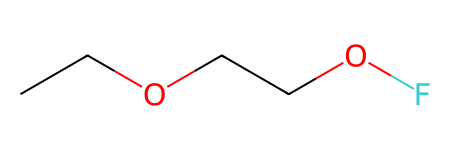

In [117]:
Chem.MolFromSmiles('CCOCCOF')
# Chem.MolFromSmiles('CCOOOP')
# Chem.MolFromSmiles('CCOCCP')
# Chem.MolFromSmiles('CCOC(=O)CN(C)CCOC')
# Chem.MolFromSmiles('COC(=O)CCN(C)C(=O)CN(C)C')
# Chem.MolFromSmiles('COCCCC(=O)N(C)C')
# Chem.MolFromSmiles('FC1(F)CCCC1')
# Chem.MolFromSmiles('COCCOCCCCN(C)C(=O)N(C)C(=O)CCl')
# Chem.MolFromSmiles('COCCOCCOCC(F)(F)C(F)F')
# Chem.MolFromSmiles('COCCCN([S](C)(=O)=O)C')
# Chem.MolFromSmiles('COCCCN(C)[S](OC)(=O)=O')
# Chem.MolFromSmiles('COCCCN(CC([F])([F])[F])C')

In [165]:
# to_me_ = pd.read_csv('./next5000_2_sugg_list_me_3rd.csv')
# to_me_emol = pd.read_csv('./emol_next_5000_me.csv')
# to_me_emol['smiles'] = to_me_emol['smiles'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))
# to_me_emol

,smiles
0,COCCCOCCS(=O)(=O)Cl
1,COCCOCCOCCCCCCCCCCC[Si](OC)(OC)OC
2,COCCCC(=O)N(C)C
3,COC(=O)CCN(C)C(=O)CN(C)C
4,CCOC(=O)CN(C)CCOC
5,CCOP(=O)(CCCCN(C)C)OCC
6,CN(C)CCOCCOCCN(C)C


In [168]:
# emol_me_bool = to_me_['solv_comb_sm'].isin(to_me_emol['smiles'])
# emol_me_ind = [i for i in range(len(emol_me_bool)) if emol_me_bool[i] == True]
# to_me_.iloc[emol_me_ind]

,Unnamed: 0,solv_comb_sm,TSNE_0,TSNE_1,database
253,262712,COCCCOCCS(=O)(=O)Cl,28.331768,-27.414627,next_5000_4
420,355646,COCCOCCOCCCCCCCCCCC[Si](OC)(OC)OC,28.356445,-27.317333,next_5000_4
437,3775,COCCCC(=O)N(C)C,26.137825,1.751998,next_5000_5
537,123933,COC(=O)CCN(C)C(=O)CN(C)C,23.739271,14.049875,next_5000_5
1047,331858,CCOC(=O)CN(C)CCOC,26.077414,1.046077,next_5000_5
1106,48829,CCOP(=O)(CCCCN(C)C)OCC,-1.567648,-29.244917,next_5000_6
1379,211998,CN(C)CCOCCOCCN(C)C,6.966732,-38.435352,next_5000_6


**File requested by Peiyuan: top 1000 with MW < 300 (11-28-23); ignore for now**

In [4]:
df_pred = pd.read_csv('preds_uncer_ei_unlabel_1mil_iter3_112323.csv')
df_pred.sort_values(by=['EI_aggr'], ascending=False, inplace=True)
df_pred

,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,norm_capacity_3_un_matern,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr
281966,281990,COCCN(C)C(=O)CCCCCCOCCCCCC(=O)N(C)CCC[Si](OC)(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.526972,0.762888,-0.043111,0.091130,-0.036244,1.783612,0.528564,...,0.382482,0.187970,0.269315,0.494795,0.380944,7.575470e-02,2.314500e-02,3.514987e-03,3.623937e-02,9.156261e-08
326343,326368,COCCCCCCN(C)C(=O)CN(C)C(=O)CN(C)C(=O)CN(C)C(=O...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.642934,0.583175,-0.193497,0.027452,0.286315,1.477630,0.542843,...,0.357940,0.187759,0.263615,0.502978,0.351917,5.683049e-02,1.863692e-02,3.101636e-03,3.029163e-02,7.669432e-08
306272,306297,COCCOCCO[Si](CCCN(C)C(=O)N(C)C)(OCCOCCOC)OCCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.539348,0.339029,0.059888,-0.275322,0.273289,1.190844,0.705424,...,0.369265,0.182751,0.266936,0.484822,0.362438,5.868211e-02,1.926822e-02,3.177950e-03,2.994509e-02,7.619361e-08
266590,266614,COCCCCCN(C)C(=O)CN(C)C(=O)CN(C)C(=O)CN(C)C(=O)...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.642934,0.583175,-0.193497,0.027452,0.286315,1.477630,0.542843,...,0.353047,0.188678,0.262494,0.506568,0.346237,5.407644e-02,1.799590e-02,3.052717e-03,2.947963e-02,7.470511e-08
208303,208324,COCCC(CCOC)(CN(C)CCC[Si](OC)(OC)OC)N(C)CCC[Si]...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.186252,-0.985954,-0.256065,-0.791327,0.030853,0.937182,1.533513,...,0.345958,0.196875,0.262425,0.519606,0.333096,4.949275e-02,1.831915e-02,3.302739e-03,2.836840e-02,7.280541e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678196,678244,FC1(F)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.617907,-1.406775,0.416785,-0.741919,0.390935,-0.492193,-0.886565,...,0.193429,-0.001741,0.154260,-0.073211,0.171982,9.640444e-08,2.181748e-07,1.475036e-07,1.245403e-09,6.197246e-13
741968,742026,CC1(Cl)CCCS1,[Li+].O=C1O[B-](F)(F)OC1=O,0.820430,-1.467499,0.619549,-0.560647,0.509421,-0.170830,-0.951468,...,0.192109,-0.002029,0.145920,-0.058733,0.171363,1.616123e-07,2.583678e-07,3.938913e-08,1.795079e-09,5.941302e-13
471147,471190,FC1(F)CCCCCCC1,[Li+].F[P-](F)(F)(F)(F)F,0.680281,-1.383992,0.402121,-0.769924,0.378534,-0.445670,-0.916712,...,0.192263,-0.000231,0.133738,-0.042478,0.171610,2.041721e-07,2.527904e-07,4.088585e-09,3.186667e-09,5.845695e-13
442664,442704,CC1(Cl)CCCS1,[Li+].F[P-](F)(F)(F)(F)F,0.820430,-1.467499,0.619549,-0.560647,0.509421,-0.170830,-0.951468,...,0.191066,-0.002474,0.145789,-0.052761,0.170963,1.972256e-07,2.038032e-07,3.793015e-08,2.033288e-09,5.665876e-13


In [28]:
df_pred['rank'] = df_pred['EI_aggr'].rank(ascending=False) ## rank in descending order
df_pred

,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr,rank
281966,281990,COCCN(C)C(=O)CCCCCCOCCCCCC(=O)N(C)CCC[Si](OC)(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.526972,0.762888,-0.043111,0.091130,-0.036244,1.783612,0.528564,...,0.187970,0.269315,0.494795,0.380944,7.575470e-02,2.314500e-02,3.514987e-03,3.623937e-02,9.156261e-08,1.0
326343,326368,COCCCCCCN(C)C(=O)CN(C)C(=O)CN(C)C(=O)CN(C)C(=O...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.642934,0.583175,-0.193497,0.027452,0.286315,1.477630,0.542843,...,0.187759,0.263615,0.502978,0.351917,5.683049e-02,1.863692e-02,3.101636e-03,3.029163e-02,7.669432e-08,2.0
306272,306297,COCCOCCO[Si](CCCN(C)C(=O)N(C)C)(OCCOCCOC)OCCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.539348,0.339029,0.059888,-0.275322,0.273289,1.190844,0.705424,...,0.182751,0.266936,0.484822,0.362438,5.868211e-02,1.926822e-02,3.177950e-03,2.994509e-02,7.619361e-08,3.0
266590,266614,COCCCCCN(C)C(=O)CN(C)C(=O)CN(C)C(=O)CN(C)C(=O)...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.642934,0.583175,-0.193497,0.027452,0.286315,1.477630,0.542843,...,0.188678,0.262494,0.506568,0.346237,5.407644e-02,1.799590e-02,3.052717e-03,2.947963e-02,7.470511e-08,4.0
208303,208324,COCCC(CCOC)(CN(C)CCC[Si](OC)(OC)OC)N(C)CCC[Si]...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.186252,-0.985954,-0.256065,-0.791327,0.030853,0.937182,1.533513,...,0.196875,0.262425,0.519606,0.333096,4.949275e-02,1.831915e-02,3.302739e-03,2.836840e-02,7.280541e-08,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678196,678244,FC1(F)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.617907,-1.406775,0.416785,-0.741919,0.390935,-0.492193,-0.886565,...,-0.001741,0.154260,-0.073211,0.171982,9.640444e-08,2.181748e-07,1.475036e-07,1.245403e-09,6.197246e-13,999926.0
741968,742026,CC1(Cl)CCCS1,[Li+].O=C1O[B-](F)(F)OC1=O,0.820430,-1.467499,0.619549,-0.560647,0.509421,-0.170830,-0.951468,...,-0.002029,0.145920,-0.058733,0.171363,1.616123e-07,2.583678e-07,3.938913e-08,1.795079e-09,5.941302e-13,999927.0
471147,471190,FC1(F)CCCCCCC1,[Li+].F[P-](F)(F)(F)(F)F,0.680281,-1.383992,0.402121,-0.769924,0.378534,-0.445670,-0.916712,...,-0.000231,0.133738,-0.042478,0.171610,2.041721e-07,2.527904e-07,4.088585e-09,3.186667e-09,5.845695e-13,999928.0
442664,442704,CC1(Cl)CCCS1,[Li+].F[P-](F)(F)(F)(F)F,0.820430,-1.467499,0.619549,-0.560647,0.509421,-0.170830,-0.951468,...,-0.002474,0.145789,-0.052761,0.170963,1.972256e-07,2.038032e-07,3.793015e-08,2.033288e-09,5.665876e-13,999929.0


In [19]:
df_low_mw = df_pred.loc[df_pred['mol_wt_solv'] <= 300].drop_duplicates(subset=['solv_comb_sm'], keep='first')
df_low_mw

,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr,rank
308919,308944,COCCOCCCCN(C)C(=O)CN(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.336661,0.674032,-0.280308,-0.163198,0.148098,1.626789,0.705458,...,0.205477,0.250785,0.530940,0.302957,3.174156e-02,1.338163e-02,2.763432e-03,2.295623e-02,5.679284e-08,23.0
328649,328674,COCCOCCCCN(C)C(=O)N(C)C(=O)CCl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.293644,0.566338,-0.135333,-0.172533,0.093215,1.593875,0.662879,...,0.206522,0.249846,0.537411,0.293272,3.131774e-02,1.300195e-02,2.731970e-03,2.168511e-02,5.655524e-08,24.0
320606,320631,COCCCN(C)C(=O)CN(C)CCC(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.654820,0.732419,-0.186912,-0.064044,0.342462,1.364558,0.528045,...,0.194037,0.253951,0.514553,0.312622,3.351635e-02,1.316262e-02,2.646877e-03,2.278490e-02,5.627251e-08,26.0
304975,305000,COCCOCC(=O)N(C)CCCCC(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.716766,0.693781,-0.084404,0.016856,0.366888,1.429730,0.491781,...,0.195987,0.252777,0.520887,0.303860,3.222542e-02,1.264006e-02,2.626227e-03,2.171718e-02,5.530289e-08,31.0
299863,299888,COCCCCCCN(C)C(=O)CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.678935,0.609334,-0.095133,-0.013704,0.303443,1.473438,0.505132,...,0.197413,0.251630,0.521777,0.299551,3.103813e-02,1.235011e-02,2.593221e-03,2.088717e-02,5.408925e-08,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882620,882687,BC1(C)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.767836,-1.447923,0.619568,-0.633468,0.503057,-0.063610,-0.993267,...,0.000778,0.172942,-0.063353,0.174567,1.665944e-07,3.703272e-07,1.605307e-06,2.719183e-09,2.822344e-12,999513.0
953551,953619,O=C1CCC2(CCCCS2)CC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.869855,-1.141136,0.980343,-0.269667,0.789873,-0.297611,-1.190809,...,0.005427,0.163453,-0.040052,0.179789,4.416892e-07,9.211510e-07,6.196662e-07,1.294919e-08,2.555359e-12,999559.0
981426,981494,CC12CCCC(F)(CC1)CC2,[Li+].O=C1O[B-](F)(F)OC1=O,0.746890,-1.413161,0.637293,-0.630554,0.591712,-0.122630,-0.867561,...,-0.001305,0.156384,-0.045444,0.171543,2.280097e-07,3.479975e-07,2.023812e-07,2.861418e-09,1.027874e-12,999870.0
828420,828485,[Si]C1([Si])CCCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.813155,-1.421234,0.552128,-0.622831,0.491489,-0.021924,-0.949165,...,-0.000340,0.133646,-0.028350,0.169728,2.724705e-07,3.855281e-07,3.990538e-09,3.632449e-09,8.444911e-13,999900.0


In [20]:
top_1000_uniq = df_low_mw.iloc[:1000,:]
# top_1000['rank'] = [i for i in range(1,1001)]
# top_1000['mw'] = top_1000['solv_comb_sm'].apply(lambda x: rdMolDescriptors.CalcExactMolWt(Chem.MolFromSmiles(x)))
top_1000_uniq['mean_pred'] = top_1000_uniq.apply(lambda x: (x['norm_capacity_3_rq'] + x['norm_capacity_3_matern'] + x['norm_capacity_3_rbfexpsin'] + x['norm_capacity_3_pair'])/4, axis=1)
top_1000_uniq

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_68342/2305231810.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_1000_uniq['mean_pred'] = top_1000_uniq.apply(lambda x: (x['norm_capacity_3_rq'] + x['norm_capacity_3_matern'] + x['norm_capacity_3_rbfexpsin'] + x['norm_capacity_3_pair'])/4, axis=1)


,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr,rank,mean_pred
308919,308944,COCCOCCCCN(C)C(=O)CN(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.336661,0.674032,-0.280308,-0.163198,0.148098,1.626789,0.705458,...,0.250785,0.530940,0.302957,0.031742,0.013382,0.002763,0.022956,5.679284e-08,23.0,0.427264
328649,328674,COCCOCCCCN(C)C(=O)N(C)C(=O)CCl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.293644,0.566338,-0.135333,-0.172533,0.093215,1.593875,0.662879,...,0.249846,0.537411,0.293272,0.031318,0.013002,0.002732,0.021685,5.655524e-08,24.0,0.433167
320606,320631,COCCCN(C)C(=O)CN(C)CCC(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.654820,0.732419,-0.186912,-0.064044,0.342462,1.364558,0.528045,...,0.253951,0.514553,0.312622,0.033516,0.013163,0.002647,0.022785,5.627251e-08,26.0,0.414701
304975,305000,COCCOCC(=O)N(C)CCCCC(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.716766,0.693781,-0.084404,0.016856,0.366888,1.429730,0.491781,...,0.252777,0.520887,0.303860,0.032225,0.012640,0.002626,0.021717,5.530289e-08,31.0,0.419092
299863,299888,COCCCCCCN(C)C(=O)CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.678935,0.609334,-0.095133,-0.013704,0.303443,1.473438,0.505132,...,0.251630,0.521777,0.299551,0.031038,0.012350,0.002593,0.020887,5.408925e-08,36.0,0.420369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332672,332697,COCCOCCN(C)CC(=O)N(C)C(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.696154,0.589133,-0.351037,-0.733344,-0.454881,0.108091,0.477559,...,0.243329,0.422967,0.283149,0.010646,0.006900,0.002441,0.008221,2.420262e-08,1865.0,0.356988
178174,178193,CCCCOP(=O)(OC)ON(C)CCN(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.394226,-0.926776,-0.568927,0.409673,-0.104702,1.361943,0.384678,...,0.238895,0.454122,0.253920,0.011014,0.005700,0.002643,0.006564,2.420094e-08,1866.0,0.385633
238162,238186,CCN(C)C(=O)C(=O)N(C)CCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.473288,0.281153,-0.086215,-0.215933,0.151089,1.036473,0.553687,...,0.239077,0.445172,0.264432,0.011287,0.006061,0.002012,0.007292,2.420079e-08,1867.0,0.373635
213347,213369,CCCCOCCCN(C)P(=O)(OC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.127452,-0.882332,-0.475302,0.409552,-0.360824,1.632316,0.494943,...,0.235900,0.466190,0.243239,0.010479,0.005651,0.002932,0.006021,2.420034e-08,1868.0,0.399227


In [21]:
top_1000_uniq['solv_comb_sm'].unique().shape

(1000,)

In [25]:
list_top_1000_bool = df_comb_tsne['solv_comb_sm'].isin(top_1000_uniq['solv_comb_sm'])
top_1000_ind = [i for i in range(len(list_top_1000_bool)) if list_top_1000_bool[i] == True]
df_comb_tsne.loc[top_1000_ind, 'database'] = 'top_1000'
df_comb_tsne.loc[top_1000_ind]

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database
11483,COCCCN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.467365,0.455105,-0.002142,-0.272471,0.242055,1.141966,0.589054,1.178044,...,174.136828,186.939685,1.0,0.0,150,50,2,-23.407833,-31.353483,top_1000
16089,COCCCN(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.059886,-0.954092,-0.402727,-0.634028,-0.264763,1.128454,0.973081,1.359149,...,117.115364,186.939685,1.0,0.0,150,50,2,6.494154,-8.794989,top_1000
24009,COCCCN(C)CF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.042556,-1.066831,-0.261827,-0.637035,-0.226290,1.051947,1.076999,1.290270,...,135.105942,186.939685,1.0,0.0,150,50,2,6.499509,-8.788438,top_1000
29946,COP(=O)(OC)OCCCN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.434083,0.411609,-0.009612,-0.237173,0.399295,1.023127,0.375851,1.002269,...,268.118808,186.939685,1.0,0.0,150,50,2,0.703087,-17.570810,top_1000
30492,CCOP(=O)(OCC)N(C)CCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.264286,-0.668926,-0.305171,-0.076662,-0.205559,1.190004,0.708238,1.174421,...,239.128645,186.939685,1.0,0.0,150,50,2,6.208502,-8.807446,top_1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332559,CCN(C)C(=O)CN(C)CCCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.735126,0.354074,-0.332793,0.348369,0.119716,1.599132,0.478509,1.095515,...,230.199428,186.939685,1.0,0.0,150,50,2,2.507675,-31.166487,top_1000
332613,CCCCOCCCN(C)C(=O)N(C)C(=O)CCl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.348302,0.196190,-0.790631,0.884124,0.578871,1.566882,-0.145835,0.048658,...,278.139720,186.939685,1.0,0.0,150,50,2,-24.653168,-24.850508,top_1000
332697,COCCOCCN(C)CC(=O)N(C)C(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.696154,0.589133,-0.351037,-0.733344,-0.454881,0.108091,0.477559,0.948571,...,246.194343,186.939685,1.0,0.0,150,50,2,17.328592,-0.314479,top_1000
333104,CCCN(C)C(=O)N(C)CCCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.444082,0.277325,-0.391683,0.358161,-0.101473,1.742547,0.569895,0.605484,...,246.194343,186.939685,1.0,0.0,150,50,2,2.343527,-31.393562,top_1000


In [27]:
df_top_1000_tsne = df_comb_tsne.loc[df_comb_tsne['database'] == 'top_1000']
df_top_1000_tsne['rank'] = df_top_1000_tsne['solv_comb_sm'].apply(lambda x: top_1000_uniq.loc[top_1000_uniq['solv_comb_sm'] == x]['rank'].values[0])
df_top_1000_tsne['mean_pred'] = df_top_1000_tsne['solv_comb_sm'].apply(lambda x: top_1000_uniq.loc[top_1000_uniq['solv_comb_sm'] == x]['mean_pred'].values[0])
df_top_1000_tsne['index_0'] = df_top_1000_tsne['solv_comb_sm'].apply(lambda x: top_1000_uniq.loc[top_1000_uniq['solv_comb_sm'] == x]['index_0'].values[0])
df_top_1000_tsne

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_68342/1247727954.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_1000_tsne['rank'] = df_top_1000_tsne['solv_comb_sm'].apply(lambda x: top_1000_uniq.loc[top_1000_uniq['solv_comb_sm'] == x]['rank'].values[0])
/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_68342/1247727954.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_1000_tsne['mean_pred'] = df_top_1000_tsne['solv_comb_sm'].apply(lambda x: top_1000_uniq.loc[top_1000

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database,rank,mean_pred,index_0
11483,COCCCN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.467365,0.455105,-0.002142,-0.272471,0.242055,1.141966,0.589054,1.178044,...,0.0,150,50,2,-23.407833,-31.353483,top_1000,1321.0,0.381050,11483
16089,COCCCN(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.059886,-0.954092,-0.402727,-0.634028,-0.264763,1.128454,0.973081,1.359149,...,0.0,150,50,2,6.494154,-8.794989,top_1000,1382.0,0.399783,16089
24009,COCCCN(C)CF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.042556,-1.066831,-0.261827,-0.637035,-0.226290,1.051947,1.076999,1.290270,...,0.0,150,50,2,6.499509,-8.788438,top_1000,1864.0,0.405600,24009
29946,COP(=O)(OC)OCCCN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.434083,0.411609,-0.009612,-0.237173,0.399295,1.023127,0.375851,1.002269,...,0.0,150,50,2,0.703087,-17.570810,top_1000,1485.0,0.371873,29946
30492,CCOP(=O)(OCC)N(C)CCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.264286,-0.668926,-0.305171,-0.076662,-0.205559,1.190004,0.708238,1.174421,...,0.0,150,50,2,6.208502,-8.807446,top_1000,1373.0,0.402694,30492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332559,CCN(C)C(=O)CN(C)CCCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.735126,0.354074,-0.332793,0.348369,0.119716,1.599132,0.478509,1.095515,...,0.0,150,50,2,2.507675,-31.166487,top_1000,206.0,0.406129,332559
332613,CCCCOCCCN(C)C(=O)N(C)C(=O)CCl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.348302,0.196190,-0.790631,0.884124,0.578871,1.566882,-0.145835,0.048658,...,0.0,150,50,2,-24.653168,-24.850508,top_1000,1763.0,0.339982,332613
332697,COCCOCCN(C)CC(=O)N(C)C(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.696154,0.589133,-0.351037,-0.733344,-0.454881,0.108091,0.477559,0.948571,...,0.0,150,50,2,17.328592,-0.314479,top_1000,1865.0,0.356988,332697
333104,CCCN(C)C(=O)N(C)CCCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.444082,0.277325,-0.391683,0.358161,-0.101473,1.742547,0.569895,0.605484,...,0.0,150,50,2,2.343527,-31.393562,top_1000,404.0,0.403389,333104


In [30]:
top_1000_uniq.loc[top_1000_uniq['index_0'] == 586238]

,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr,rank,mean_pred
586192,586238,COCCCN(C)C(=O)CCC[Si](OC)(OC)OC,[Li+].F[P-](F)(F)(F)(F)F,-1.678882,0.722889,0.001616,-0.096202,0.212744,1.268084,0.463859,...,0.25637,0.369834,0.316752,0.014183,0.00698,0.001816,0.009026,2.474176e-08,1748.0,0.307379


In [31]:
top_1000_fin = df_top_1000_tsne[['index_0', 'solv_comb_sm', 'rank', 'mean_pred', 'TSNE_0', 'TSNE_1']]
top_1000_fin

,index_0,solv_comb_sm,rank,mean_pred,TSNE_0,TSNE_1
11483,11483,COCCCN(C)C(=O)N(C)C,1321.0,0.381050,-23.407833,-31.353483
16089,16089,COCCCN(C)C,1382.0,0.399783,6.494154,-8.794989
24009,24009,COCCCN(C)CF,1864.0,0.405600,6.499509,-8.788438
29946,29946,COP(=O)(OC)OCCCN(C)C(=O)N(C)C,1485.0,0.371873,0.703087,-17.570810
30492,30492,CCOP(=O)(OCC)N(C)CCCOC,1373.0,0.402694,6.208502,-8.807446
...,...,...,...,...,...,...
332559,332559,CCN(C)C(=O)CN(C)CCCCCOC,206.0,0.406129,2.507675,-31.166487
332613,332613,CCCCOCCCN(C)C(=O)N(C)C(=O)CCl,1763.0,0.339982,-24.653168,-24.850508
332697,332697,COCCOCCN(C)CC(=O)N(C)C(C)C,1865.0,0.356988,17.328592,-0.314479
333104,333104,CCCN(C)C(=O)N(C)CCCOCCOC,404.0,0.403389,2.343527,-31.393562


In [3]:
# top_1000_fin.to_csv('mw300_top_1000uniq_sugg_ei_iter3_112823.csv', index=False)
top_1000_fin = pd.read_csv('mw300_top_1000uniq_sugg_ei_iter3_112823.csv')

In [35]:

def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc

def moltosvg(mol,molSize=(250,100),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return SVG(svg.replace('svg:',''))

PandasTools.AddMoleculeColumnToFrame(top_1000_fin,'solv_comb_sm', 'solv')

svgs_solv = [moltosvg(m).data for m in top_1000_fin.solv]
smile = top_1000_fin['solv_comb_sm'].values.tolist()
# database_class = top_1000_fin['database'].values.tolist()
rank = top_1000_fin['rank'].values.tolist()
preds = top_1000_fin['mean_pred'].values.tolist()
ind = top_1000_fin['index_0'].values.tolist()
ChangeMoleculeRendering(renderer='PNG')

# source = ColumnDataSource(data=dict(x=df_comb_tsne__['TSNE_0'], y=df_comb_tsne__['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, color_column_name=df_comb_tsne__['database']))
source = ColumnDataSource(data=dict(x=top_1000_fin['TSNE_0'], y=top_1000_fin['TSNE_1'], svgs_solv=svgs_solv, desc=rank, smile=smile, ind=ind, preds=preds))

hover = HoverTool(tooltips="""
    <div>
        <div> 
            <span style="font-size: 12px; font-weight: bold;"> @svgs_solv{safe} </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> SMILES: @smile </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Rank: @desc </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Prediction: @preds </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Index: @ind </span>
        </div>
    </div>
    """
)

interactive_map = figure(width=1000, height=1000, tools=['reset,box_zoom,wheel_zoom,zoom_in,zoom_out,pan',hover])
interactive_map.title.text = "Top 1000 unique suggestions from AL (iteration-3) (MW <= 300)"
interactive_map.title.align = "center"
interactive_map.title.text_color = "orange"
interactive_map.title.text_font_size = "25px"

interactive_map.scatter('x', 'y', 
                        # color={'field': df_comb_tsne_['database'], 'transform': color_map},
                        # color = 'color',
                        # legend='top_right', ## does not work
                        source=source, size=7, fill_alpha=0.8)
output_file("interactive_top1000_mw300_sugg_al_112823.html")
save(interactive_map)

'/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/AL-CE/08-22-23/campaign-3/interactive_top1000_mw300_sugg_al_112823.html'

Searching for three new molecules requested by Peiyuan (12-4-23)

In [20]:
smi_1 = Chem.MolToSmiles(Chem.MolFromSmiles('COCCCN([S](C)(=O)=O)C'))
smi_1_c = Chem.MolToSmiles(Chem.MolFromSmiles('COCCN([S](C)(=O)=O)C'))
smi_2 = Chem.MolToSmiles(Chem.MolFromSmiles('COCCCN(CC([F])([F])[F])C'))
smi_2_c = Chem.MolToSmiles(Chem.MolFromSmiles('COCCN(CC([F])([F])[F])C'))
smi_3 = Chem.MolToSmiles(Chem.MolFromSmiles('COCCCN(C)[S](OC)(=O)=O'))
smi_3_c = Chem.MolToSmiles(Chem.MolFromSmiles('COCCN(C)[S](OC)(=O)=O'))

In [23]:
df_pred.loc[df_pred['solv_comb_sm'] == smi_1]
df_pred.loc[df_pred['solv_comb_sm'] == smi_2]
df_pred.loc[df_pred['solv_comb_sm'] == smi_3]

,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,norm_capacity_3_un_matern,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr
303431,303456,COCCN(C)S(=O)(=O)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.004048,-0.583223,-0.093992,-0.777311,-0.012882,0.712017,0.845391,...,0.25119,0.222727,0.230835,0.4571,0.241255,0.009002,0.005798,0.002009,0.0053,2.171096e-08


In [35]:
alt_1 = df_pred.loc[df_pred['solv_comb_sm'] == smi_1_c] ## index -> 324225; rank -> 2942
alt_2 = df_pred.loc[df_pred['solv_comb_sm'] == smi_2_c] ## index -> 211170; rank -> 1965
alt_3 = df_pred.loc[df_pred['solv_comb_sm'] == smi_3_c] ## index -> 303456; rank -> 2532
alt_3

,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr,rank
303431,303456,COCCN(C)S(=O)(=O)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.004048,-0.583223,-0.093992,-0.777311,-0.012882,0.712017,0.845391,...,0.222727,0.230835,0.4571,0.241255,0.009002,0.005798,0.002009,0.0053,2.171096e-08,2532.0


In [37]:
alt_fin = pd.concat([alt_1, alt_2, alt_3], axis=0)
alt_fin['mean_pred'] = alt_fin.apply(lambda x: (x['norm_capacity_3_rq'] + x['norm_capacity_3_matern'] + x['norm_capacity_3_rbfexpsin'] + x['norm_capacity_3_pair'])/4, axis=1)
alt_fin

,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr,rank,mean_pred
324200,324225,COCCN(C)S(C)(=O)=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.997594,-0.587529,-0.084673,-0.766005,-0.003629,0.705357,0.825030,...,0.229994,0.454151,0.239136,0.008367,0.005497,0.002022,0.004929,2.058846e-08,2942.0,0.391289
211149,211170,COCCN(C)CC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.021975,-1.013418,-0.169159,-1.128921,0.375974,0.726177,1.623300,...,0.229544,0.454647,0.244965,0.008813,0.007513,0.002456,0.005571,2.375130e-08,1965.0,0.402443
303431,303456,COCCN(C)S(=O)(=O)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.004048,-0.583223,-0.093992,-0.777311,-0.012882,0.712017,0.845391,...,0.230835,0.457100,0.241255,0.009002,0.005798,0.002009,0.005300,2.171096e-08,2532.0,0.393106


In [43]:
alt_fin['label'] = alt_fin.apply(lambda x: str(x['index_0']) + ' | ' + str(round(x['mean_pred'],2)) + ' | ' + str(int(x['rank'])), axis=1)
alt_fin

,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,...,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr,rank,mean_pred,label,ROMol
324200,324225,COCCN(C)S(C)(=O)=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.997594,-0.587529,-0.084673,-0.766005,-0.003629,0.705357,0.825030,...,0.239136,0.008367,0.005497,0.002022,0.004929,2.058846e-08,2942.0,0.391289,324225 | 0.39 | 2942,<rdkit.Chem.rdchem.Mol object at 0x12d6a17b0>
211149,211170,COCCN(C)CC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.021975,-1.013418,-0.169159,-1.128921,0.375974,0.726177,1.623300,...,0.244965,0.008813,0.007513,0.002456,0.005571,2.375130e-08,1965.0,0.402443,211170 | 0.4 | 1965,<rdkit.Chem.rdchem.Mol object at 0x12d6a1a50>
303431,303456,COCCN(C)S(=O)(=O)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.004048,-0.583223,-0.093992,-0.777311,-0.012882,0.712017,0.845391,...,0.241255,0.009002,0.005798,0.002009,0.005300,2.171096e-08,2532.0,0.393106,303456 | 0.39 | 2532,<rdkit.Chem.rdchem.Mol object at 0x12d6a1900>


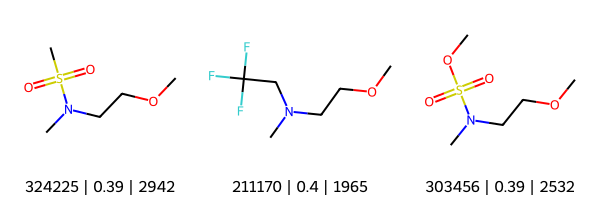

In [44]:
PandasTools.AddMoleculeColumnToFrame(alt_fin, smilesCol='solv_comb_sm')
PandasTools.FrameToGridImage(alt_fin, legendsCol='label', molsPerRow=3)


In [31]:
top_1000_fin.loc[top_1000_fin['solv_comb_sm'] == smi_1]
top_1000_fin.loc[top_1000_fin['solv_comb_sm'] == smi_1_c]
top_1000_fin.loc[top_1000_fin['solv_comb_sm'] == smi_2]
top_1000_fin.loc[top_1000_fin['solv_comb_sm'] == smi_2_c]
top_1000_fin.loc[top_1000_fin['solv_comb_sm'] == smi_3]
top_1000_fin.loc[top_1000_fin['solv_comb_sm'] == smi_3_c]

,index_0,solv_comb_sm,rank,mean_pred,TSNE_0,TSNE_1


In [33]:
top_1000_fin['rank'].max()

1869.0

**ignore below...**

In [ ]:
## obtained after entering the smiles list manually into eMolecules online search & saving the results as csv
df_sugg_500_emol = pd.read_csv('sugg_emolecules_1_test2.csv')
df_sugg_500_emol['solv_comb_sm'] = df_sugg_500_emol.apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x['smiles'])), axis=1)
df_sugg_500_emol

In [163]:
list_suggest_emol_bool = df_comb_tsne['solv_comb_sm'].isin(df_sugg_500_emol['solv_comb_sm'])
sugg_ind_emol = [i for i in range(len(list_suggest_emol_bool)) if list_suggest_emol_bool[i] == True]
# sugg_ind_emol
df_tsne_2 = df_comb_tsne.copy()
df_tsne_2['database'] = 'unlabel'
df_tsne_2.loc[label_ind, 'database'] = 'label'
df_tsne_2.loc[sugg_ind_emol, 'database'] = 'suggest_emol'

In [164]:
df_comb_tsne['database'].unique()
df_tsne_2['database'].unique()

array(['unlabel', 'suggest_emol', 'label'], dtype=object)

In [ ]:
fig_scatter = px.scatter(df_tsne_2,
                         x="TSNE_0",
                         y="TSNE_1",
                         color='database',
                         hover_data=['solv_comb_sm'],
                         labels={'solv_comb_sm'},
                         width=1000,
                         height=800)
fig_scatter.update_traces(marker=dict(size=7))
fig_scatter.show()

In [174]:
len(df['solv_comb_sm'].unique())

25

In [ ]:
from electropy import molecules
# molecules.check_similarity('FC(F)C1(F)CCCS1')
ref_mol = [Chem.MolFromSmiles(sm) for sm in df['solv_comb_sm'].unique()]
ref_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in ref_mol]
def check_similarity(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol_fps = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    similarity = [DataStructs.FingerprintSimilarity(mol_fps, ref) for ref in ref_fps]
    max_sim = max(similarity)
    # max_sim = 1.0
    ind = similarity.index(max_sim)
    return max_sim, ind

for i in range(len(df_sugg_500_emol)):
    max_sim, ind = check_similarity(df_sugg_500_emol['smiles'][i])
    df_sugg_500_emol.loc[i, 'max_sim'] = max_sim
    df_sugg_500_emol.loc[i, 'label_solv_sm'] = df['solv_comb_sm'][ind]
    # print(max_sim, ind)
    # print(df['solv_comb_sm'][ind])

df_sugg_500_emol.drop(['ind'], axis=1, inplace=True)
df_sugg_500_emol

In [ ]:
df_sugg_emol_tsne = df_tsne_2.loc[df_tsne_2['database'] == 'suggest_emol'][['solv_comb_sm', 'TSNE_0', 'TSNE_1']]
PandasTools.AddMoleculeColumnToFrame(df_sugg_emol_tsne, smilesCol='solv_comb_sm')
PandasTools.FrameToGridImage(df_sugg_emol_tsne, legendsCol="solv_comb_sm", molsPerRow=5)

In [ ]:
df_sugg_emol_tsne

In [ ]:
tt = df_unlabel_.copy()
tt.sort_values(by=['norm_capacity_3_pred'], ascending=False, inplace=True)
tt